# Natural Language Processing   

Mini-Challenge 1 (LE3-LE5)   
Yannic & Ben  


# Aufgabe

You evaluate 2 different classification systems on a text classification task (examples below). You argument why you chose these systems for that case and you build, train and evaluate the system. You also do a thorough error analysis and propose theories on how to improve the systems, especially also by analysing individual cases and comparing the predictions of each system. At least one of the systems is based on a fine-tuned deep learning model.

Here you can use data from shared tasks, such as semeval, kaggle, codalab or paperwithcode for text classification.

You can submit as a group of 2 but each one has to have a significant contribution. Submission is given as a gitlab repo. I will track with the commit history if there was  a significant contribution from each participant. The repo should include the report, a python notebook to reproduce the results and a wiki with a journal or git issues that document the progress of your mini-challenge.

Since many parts of code can be online, the most important part of the submission will be the report and evaluation of the results. In the report you describe which system you used, which are the theory behind it and why you chose it. The evaluation you describe the metric chose, why this metric is good for the use case and discuss the results of the experiments and some predictions on individual test samples. Bonus points will be given if you show, that you implemented the systems yourself, and the progress/errors are documented through commits.

ADDENDUM: The classification systems can be for example tf-idf-svm, cnns or transformers, see https://gitlab.fhnw.ch/fernando.benites/npr-21-fs/-/tree/master/text_classification/20news_group for an applied example. There are other ways to go, and I am open for suggestions. Please try to understand the systems, this can be handy in the error analysis/evaluation/report or in the exam. Don't use the 20newsgroup dataset. The repo will be used in the deep dive and so this dataset is already "taken". If you receive a 404 on the repo, please contact me, I'll add you to the repo, then it should work.

Some other starting points:

https://lionbridge.ai/articles/using-deep-learning-for-end-to-end-multiclass-text-classification/

BETTER: https://medium.com/analytics-vidhya/sentiment-analysis-on-amazon-reviews-using-tf-idf-approach-c5ab4c36e7a1

GOOD: https://colab.research.google.com/github/patrickvankessel/AAPOR-Text-Analysis-2019/blob/master/Tutorial.ipynb#scrollTo=9wJQJUDHkM5w

BAD: https://medium.com/@qempsil0914/machine-learning-nlp-text-classification-with-amazon-review-data-using-python3-step-by-step-3fb0cc0cecc1

https://paperswithcode.com/task/text-classification

https://fbenites.github.io/GermEval/

https://medium.com/analytics-vidhya/fine-tuning-bert-language-model-to-get-better-results-on-text-classification-3dac5e3c348e

https://github.com/Shivampanwar/Bert-text-classification/blob/master/bert_language_model_with_sequence_classification.ipynb


# 1 Machine Learning Model - TF-idf + RandomForestClassifier

## 1.1 Libraries importieren

In [1]:
# Standard Data Science Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from tqdm.notebook import tqdm

# sklearn imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score

# nltk imports
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

ModuleNotFoundError: No module named 'pandas'

## 1.2 Datensatz einlesen

Dieser Datensatz enthält Zusammenfassungen von 16.559 Büchern, die aus Wikipedia extrahiert wurden, zusammen mit abgeglichenen Metadaten aus Freebase, einschließlich Autor, Titel und Genre des Buches.

Relevant für die npr Text Classification Minichallenge-1  sind die Spalten "genres" und "summary". 

In [2]:
# Read booksumaries.txt Dataset
df = pd.read_csv('data/booksummaries.txt', 
                 sep="\t", 
                 header=None, 
                 names=["wikipedia_id", "freebase_id", "book_title", "book_author", "pub_date","genres","summary"],
                 dtype={"wikipedia_id": np.int32, "freebase_id": str, "book_title": str, "book_author": str, "pub_date": str, "genres": str, "summary": str})

df.info()
display(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16559 entries, 0 to 16558
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   wikipedia_id  16559 non-null  int32 
 1   freebase_id   16559 non-null  object
 2   book_title    16559 non-null  object
 3   book_author   14177 non-null  object
 4   pub_date      10949 non-null  object
 5   genres        12841 non-null  object
 6   summary       16559 non-null  object
dtypes: int32(1), object(6)
memory usage: 841.0+ KB


,wikipedia_id,freebase_id,book_title,book_author,pub_date,genres,summary
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,NaN,NaN,The argument of the Enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,NaN,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...
...,...,...,...,...,...,...,...
16554,36934824,/m/0m0p0hr,Under Wildwood,Colin Meloy,2012-09-25,NaN,"Prue McKeel, having rescued her brother from ..."
16555,37054020,/m/04f1nbs,Transfer of Power,Vince Flynn,2000-06-01,"{""/m/01jfsb"": ""Thriller"", ""/m/02xlf"": ""Fiction""}",The reader first meets Rapp while he is doing...
16556,37122323,/m/0n5236t,Decoded,Jay-Z,2010-11-16,"{""/m/0xdf"": ""Autobiography""}",The book follows very rough chronological ord...
16557,37132319,/m/0n4bqb1,America Again: Re-becoming The Greatness We Ne...,Stephen Colbert,2012-10-02,NaN,Colbert addresses topics including Wall Stree...


## 1.3 Data Wrangling

Beim Data Wrangling wurden Funktionen geschrieben, die unseren Datensatz bereinigen. In einem späteren Abschnitt analysieren wir die Daten vor und nach der Bereinigung.

Hier wichtig sind dabei folgende Funktionen für das Data Wrangling:

- `extract_genres`: Extrahiert die Genres aus dem Datensatz und gibt diese als Liste zurück.
- `drop_na_duplicates`: Entfernt alle Zeilen, die NaN Werte enthalten und entfernt Duplikate.
- `wrangle_genre`: Entfernt alle Genre die weniger als x mal vorkommen.
- `wrangle_summary`: Entfernt alle Zusammenfassungen, die weniger als x Percentil enthalten.
- `analyze_dataframe`: Gibt einen kleinen Vergleich zwischen dem Datensatz vor und nach dem Data Wrangling aus, sowie die Anzahl der Genres und deren möglichen Kombinationen.

In [3]:
# function to extract genres
def extract_genres(genre_str: str):
    """
    Extract the genres from the given string.

    Parameters:
    genre_str (str): input string

    Returns:
    list: list of genres
    """
    try:
        genre_data = json.loads(genre_str)
        return list(genre_data.values())
    except:
        (json.decoder.JSONDecodeError, TypeError)
        return np.nan
    
# function to drop na rows and duplicates
def drop_na_duplicates(df: pd.DataFrame):
    """
    Drop rows with missing values in the genres and summary columns and drop duplicate rows.

    Parameters:
    df (DataFrame): input data

    Returns:
    DataFrame: data with missing values and duplicates dropped
    """
    return df.dropna(subset=['genres', 'summary']).drop_duplicates(subset=["summary"]).reset_index(drop=True)

# function to wrangle genres
def wrangle_genres(df, minimum_genre_occurence=5):
    """
    Wrangle the genres column of the given dataframe, removing rows with genres that occur less than the given minimum_genre_occurence.

    Parameters:
    df (DataFrame): input data

    Returns:
    DataFrame: data with genres wrangled
    """
    # create copy of dataframe to avoid changing the original
    df_wrangle = df.copy()

    # Turn genres into set
    df_wrangle['genres'] = df_wrangle['genres'].apply(set)

    # Convert genres sets to strings to count occurrences
    df_count = pd.DataFrame(df_wrangle['genres'].value_counts()).reset_index()
    
    # Filter rows where genres occur more than 5 times
    selected_rows = df_count[df_count['count'] > minimum_genre_occurence]['genres']
    df_wrangle = df_wrangle[df_wrangle['genres'].isin(selected_rows)]
    
    # Turn back into list
    df_wrangle['genres'] = df_wrangle['genres'].apply(list)

    return df_wrangle

# function to wrangle summary
def wrangle_summary(df, minimum_quantile=0.01):
    """
    Wrangle the summary column of the given dataframe, removing rows with summaries that are longer than the given minimum_quantile.

    Parameters:
    df (DataFrame): input data

    Returns:
    DataFrame: data with summaries wrangled
    """
    # create copy of dataframe to avoid changing the original
    df_wrangle = df.copy()

    # Filter rows where summaries are shorter than 10% quantile
    df_wrangle = df_wrangle[df_wrangle['summary'].str.len() > df_wrangle['summary'].str.len().quantile(minimum_quantile)]

    return df_wrangle

# function to analyze the difference between two DataFrames
def analyze_dataframe(df, df_wrangled):
    """
    Analyze the difference between two DataFrames.

    Parameters:
    df (DataFrame): original DataFrame
    df_wrangled (DataFrame): wrangled DataFrame

    Returns:
    dict: a dictionary containing the analysis results
    """
    analysis_results = {}
    
    # Calculate the number of dropped rows
    num_dropped_rows = df.shape[0] - df_wrangled.shape[0]
    analysis_results["Number of dropped rows"] = num_dropped_rows
    
    # Calculate the relative number of dropped rows in percent and round to 2 decimal places
    relative_dropped_percent = round((num_dropped_rows / df.shape[0]) * 100, 2)
    analysis_results["Relative number of dropped rows in percent"] = f"{relative_dropped_percent}%"
    
    # Calculate the number of unique genres
    num_unique_genres = df_wrangled['genres'].explode().nunique()
    analysis_results["Number of unique genres"] = num_unique_genres

    # copy Dataframe to avoid changing the original
    df_wrangle = df_wrangled.copy()

    # count unique combinations of elemnts in lists within a specified DataFrame column
    df_wrangle['genres'] = df_wrangle['genres'].apply(lambda x: set(sorted(x)) if isinstance(x, list) else x)
    
    # Count occurrences of each unique combination
    combination_counts = df_wrangle['genres'].value_counts().reset_index().shape[0]
    analysis_results["Number of unique genre combinations"] = combination_counts
    
    return analysis_results

# copy Dataframe to avoid changing the original
df_unwrangled = df.copy()

# Start Data Wrangling
# apply extract_genres function to the genres column
df_unwrangled['genres'] = df_unwrangled['genres'].apply(extract_genres)

# create a copy for later analysis
df_unwrangled_analysis = df_unwrangled.copy()

# drop na rows and duplicates
df_unwrangled = drop_na_duplicates(df=df_unwrangled)

# wrangle genres
df_unwrangled = wrangle_genres(df=df_unwrangled, minimum_genre_occurence=5)

# wrangle summary
df_wrangled = wrangle_summary(df=df_unwrangled, minimum_quantile=0.01)

# display wrangled dataframe
display(df_wrangled)

# analyze the difference between the original and the wrangled dataframe
print(analyze_dataframe(df=df, df_wrangled=df_wrangled))



,wikipedia_id,freebase_id,book_title,book_author,pub_date,genres,summary
6,4081,/m/01b4w,Blade Runner 3: Replicant Night,K. W. Jeter,1996-10-01,"[Speculative fiction, Science Fiction]","Living on Mars, Deckard is acting as a consul..."
7,4082,/m/01b56,Blade Runner 2: The Edge of Human,K. W. Jeter,1995-10-01,"[Speculative fiction, Science Fiction]",Beginning several months after the events in ...
9,6020,/m/01t5z,Crash,J. G. Ballard,1973,"[Speculative fiction, Fiction, Novel]",The story is told through the eyes of narrato...
10,6628,/m/01y92,Children of Dune,Frank Herbert,1976,"[Speculative fiction, Fiction, Science Fiction...",Nine years after Emperor Paul Muad'dib walked...
12,6630,/m/01yb0,Chapterhouse Dune,Frank Herbert,1985-04,"[Speculative fiction, Fiction, Science Fiction...",The situation is desperate for the Bene Gesse...
...,...,...,...,...,...,...,...
12811,36126792,/m/044psh,Gates of Paradise,V. C. Andrews,1989-06,"[Gothic fiction, Young adult literature]","A novel about Annie Stonewall, the daughter o..."
12812,36372465,/m/02vqwsp,The Third Lynx,Timothy Zahn,2007,[Science Fiction],The story starts with former government agent...
12813,36534061,/m/072y44,Remote Control,Andy McNab,1997,"[Fiction, Thriller, Suspense]",The series follows the character of Nick Ston...
12814,37054020,/m/04f1nbs,Transfer of Power,Vince Flynn,2000-06-01,"[Fiction, Thriller]",The reader first meets Rapp while he is doing...


{'Number of dropped rows': 6675, 'Relative number of dropped rows in percent': '40.31%', 'Number of unique genres': 57, 'Number of unique genre combinations': 228}


## 1.4 Explorative Daten Analyse

**Fehlende Werte**   
In einem ersten Schritt visualisieren wir mittels einem Barplot die Fehlenden Werte für jede Spalte vor und nach dem Data Wrangling. Dabei stellen wir fest, dass es 3718 Werte gibt, die in der Spalte "genres" fehlen. Da wir diese Spalte für die Text Classification benötigen, wurden diese entfernt. Die anderen Spalten in denen fehlende Werte vorhanden sind, ist für unsere Text Classification nicht relevant und wurden deshalb auch nicht berücksichtigt beim Data Wrangling.


**Anzahl Genres**   
Ein Buch kann ein bis mehrere Genre aufweisen. In der Spalte "genres" sind die Genres mit einem Komma getrennt. Wir haben die Anzahl Genres pro Buch gezählt und in einem Barplot visualisiert. Dabei haben wir festgestellt, dass es viele Bücher gab die mehrere Genre aufweisen können. Wir wissen durch die Funktion "anlazye_dataframe", dass wir 57 Genres haben. Jedoch kann ein Buch mehrere Genre aufweisen und haben somit 228 einzigartige kombinierte Genres. Weiter haben wir Genre entfernt, die weniger als 5 mal in unserem Datensatz vorkommen, um später bei der Klassifizierung eine bessere Performance zu erhalten. Die Visualisierung bei den Flop 5 Genres vor und nach dem Data Wrangling ist unten zu sehen.

**Anzahl Wörter**   
Weiter wurde auch die Spalte "summary" betrachtet und festgestellt, dass es manchmal Bücher gab die nur aus Sonderzeichen bestanden oder nur aus wenigen Worten, sprich ein Satz. Es wurden Bücher entfernt die weniger als 1 Percentil Länge aufweisen. Dies mit dem Hintergedanke, dass diese Bücher nicht aussagekräftig sind für die Text Classification, da sie zu kurz sind.



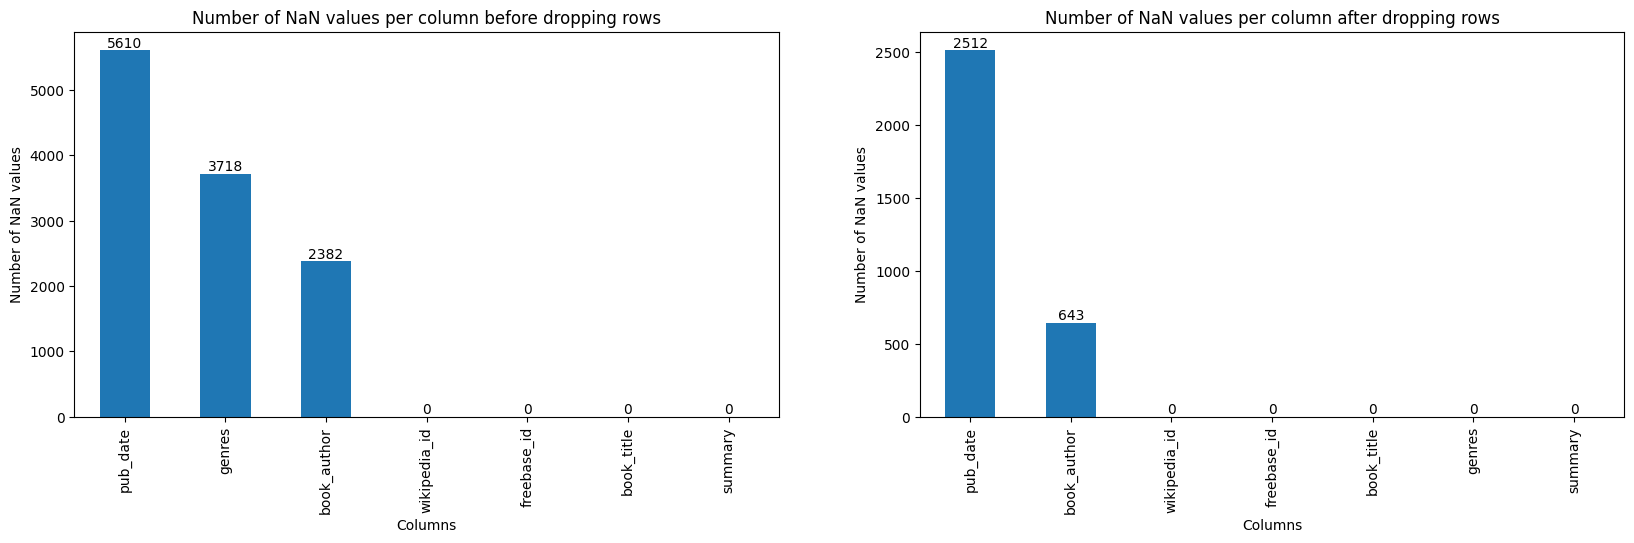

In [4]:
# befor and after data wrangling
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
df.isna().sum().sort_values(ascending=False).plot(kind='bar', ax=axes[0])
for index, value in enumerate(df.isna().sum().sort_values(ascending=False)):
    axes[0].text(index, value, str(value), ha='center', va='bottom', fontsize=10)
axes[0].set_title('Number of NaN values per column before dropping rows')
axes[0].set_xlabel('Columns')
axes[0].set_ylabel('Number of NaN values')

df_wrangled.isna().sum().sort_values(ascending=False).plot(kind='bar', ax=axes[1])
for index, value in enumerate(df_wrangled.isna().sum().sort_values(ascending=False)):
    axes[1].text(index, value, str(value), ha='center', va='bottom', fontsize=10)
axes[1].set_title('Number of NaN values per column after dropping rows')
axes[1].set_xlabel('Columns')
axes[1].set_ylabel('Number of NaN values')
plt.show()

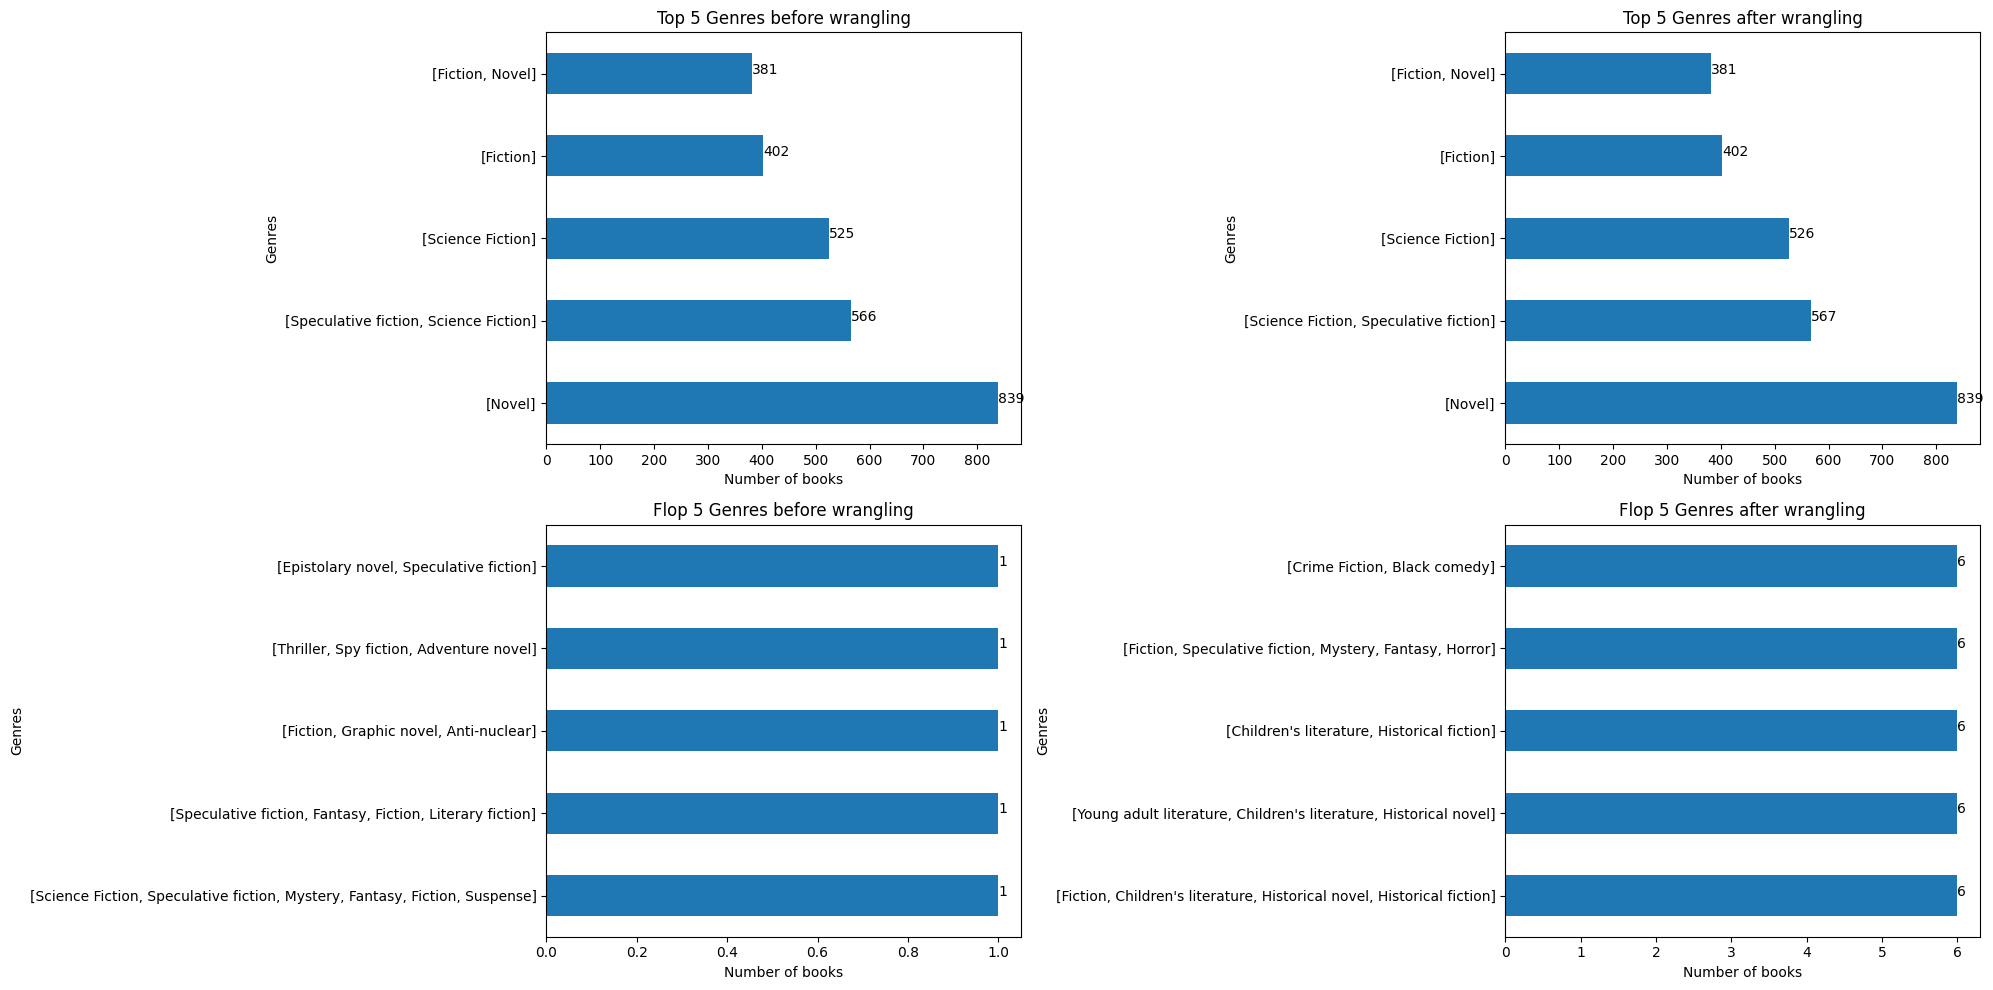

In [5]:
# Create 4 subplots for top 5 Genres and Flop 5 Genres for the df and df_wrangled
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
df_unwrangled["genres"].value_counts().head(n=5).plot(kind='barh', ax=axes[0, 0])
for index, value in enumerate(df_unwrangled["genres"].value_counts().head(n=5)):
    axes[0, 0].text(value, index, str(value))
axes[0, 0].set_title('Top 5 Genres before wrangling')
axes[0, 0].set_xlabel('Number of books')
axes[0, 0].set_ylabel('Genres')

df_unwrangled_analysis["genres"].value_counts().head(n=5).plot(kind='barh', ax=axes[0, 1])
for index, value in enumerate(df_unwrangled_analysis["genres"].value_counts().head(n=5)):
    axes[0, 1].text(value, index, str(value))
axes[0, 1].set_title('Top 5 Genres after wrangling')
axes[0, 1].set_xlabel('Number of books')
axes[0, 1].set_ylabel('Genres')

df_unwrangled_analysis["genres"].value_counts().tail(n=5).plot(kind='barh', ax=axes[1, 0])
for index, value in enumerate(df_unwrangled_analysis["genres"].value_counts().tail(n=5)):
    axes[1, 0].text(value, index, str(value))
axes[1, 0].set_title('Flop 5 Genres before wrangling')
axes[1, 0].set_xlabel('Number of books')
axes[1, 0].set_ylabel('Genres')

df_wrangled["genres"].value_counts().tail(n=5).plot(kind='barh', ax=axes[1, 1])
for index, value in enumerate(df_wrangled["genres"].value_counts().tail(n=5)):
    axes[1, 1].text(value, index, str(value))
axes[1, 1].set_title('Flop 5 Genres after wrangling')
axes[1, 1].set_xlabel('Number of books')
axes[1, 1].set_ylabel('Genres')

plt.tight_layout()
plt.show()


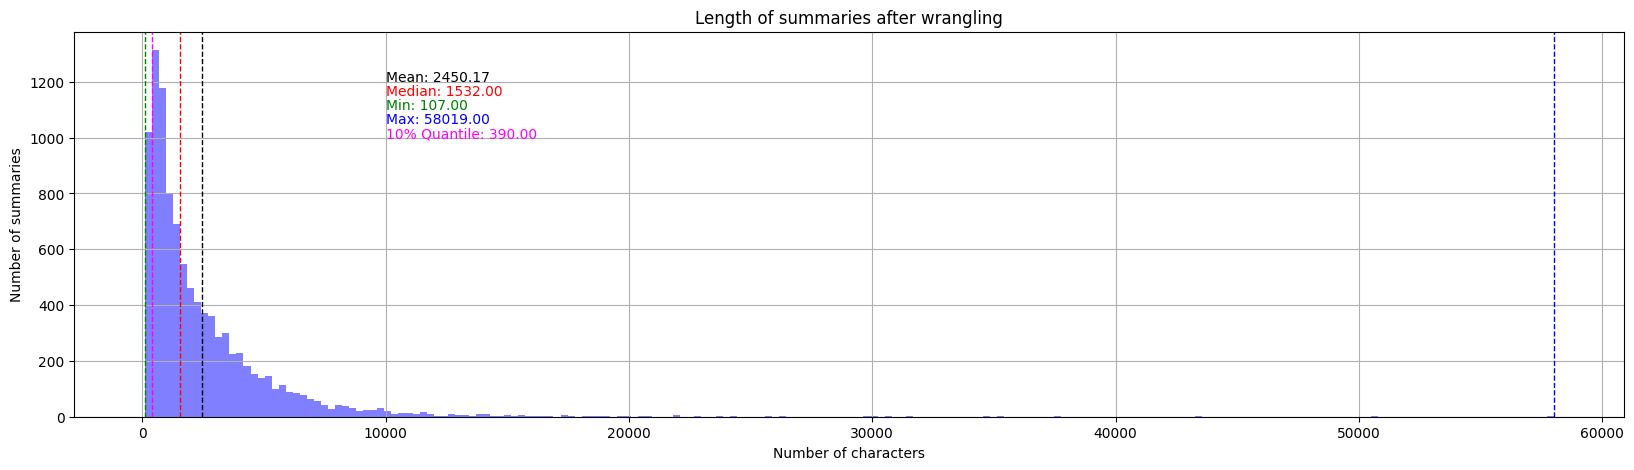

In [6]:
# create a histogram of the len of the summaries
df_wrangled['summary'].str.len().hist(figsize=(20, 5), bins=200, color='blue', alpha = 0.5)
plt.axvline(df_wrangled['summary'].str.len().mean(), color='black', linestyle='dashed', linewidth=1)
plt.axvline(df_wrangled['summary'].str.len().median(), color='r', linestyle='dashed', linewidth=1)
plt.axvline(df_wrangled['summary'].str.len().min(), color='g', linestyle='dashed', linewidth=1)
plt.axvline(df_wrangled['summary'].str.len().max(), color='b', linestyle='dashed', linewidth=1)
plt.axvline(df_wrangled['summary'].str.len().quantile(0.1), color='magenta', linestyle='dashed', linewidth=1)

mean_length = df_wrangled['summary'].str.len().mean()
median_length = df_wrangled['summary'].str.len().median()
min_length = df_wrangled['summary'].str.len().min()
max_length = df_wrangled['summary'].str.len().max()
quantile_10 = df_wrangled['summary'].str.len().quantile(0.1)

# add labels from axvline
plt.text(10000, 1200, f'Mean: {mean_length:.2f}', fontsize=10, color='black')
plt.text(10000, 1150, f'Median: {median_length:.2f}', fontsize=10, color='r')
plt.text(10000, 1100, f'Min: {min_length:.2f}', fontsize=10, color='g')
plt.text(10000, 1050, f'Max: {max_length:.2f}', fontsize=10, color='b')
plt.text(10000, 1000, f'10% Quantile: {quantile_10:.2f}', fontsize=10, color='magenta')

plt.title('Length of summaries after wrangling')
plt.xlabel('Number of characters')
plt.ylabel('Number of summaries')
plt.show()

## 1.5 Data NLP Pre-processing

Für die Text Klassifikation wurden folgende Pre-Processing Schritte durchgeführt:
- lower: Alle Wörter wurden in Kleinbuchstaben umgewandelt.
- punctuation: Alle Satzzeichen wurden entfernt.
- stopwords: Alle Stopwords wurden entfernt.
- lemmatization: Alle Wörter wurden auf ihren Wortstamm zurückgeführt.
- tokenization: Alle Wörter wurden in Tokens umgewandelt.

Alle diese Schritte sind unter der Funktion `preprocess_summary` zusammengefasst, welche uns eine Liste mit den vorverarbeiteten Texten zurückgibt.

In einem weiteren Schritt wurde noch ein Pos-Tag durchgeführt, um die Wortarten zu bestimmen. Dies mit dem Hintergedanken, dass wir später die Wortarten ebenfalls als ein weiteres Feature verwenden können.


In [7]:
# select the relevant columns
df_nlp = df_wrangled[['genres', 'summary']].copy()

# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))

# preprocess Summary column and add it to the dataframe
def preprocess_summary(summary_text: str):
    # case folding to lower case 
    summary_text = summary_text.lower()
    # remove punctuation, kommas, dots, and other special characters
    summary_text = summary_text.translate(str.maketrans('', '', string.punctuation))
    # remove stopwords
    summary_text = [word for word in summary_text.split() if word not in stop_words]
    # lemmatize words
    summary_text = [WordNetLemmatizer().lemmatize(word) for word in summary_text]
    # Tokenize
    summary_text = word_tokenize(" ".join(summary_text))
    return summary_text

# apply preprocess function to Summary column
df_nlp['tokens'] = df_nlp['summary'].apply(preprocess_summary)

# display dataframe
display(df_nlp)

,genres,summary,tokens
6,"[Speculative fiction, Science Fiction]","Living on Mars, Deckard is acting as a consul...","[living, mar, deckard, acting, consultant, mov..."
7,"[Speculative fiction, Science Fiction]",Beginning several months after the events in ...,"[beginning, several, month, event, blade, runn..."
9,"[Speculative fiction, Fiction, Novel]",The story is told through the eyes of narrato...,"[story, told, eye, narrator, james, ballard, n..."
10,"[Speculative fiction, Fiction, Science Fiction...",Nine years after Emperor Paul Muad'dib walked...,"[nine, year, emperor, paul, muaddib, walked, d..."
12,"[Speculative fiction, Fiction, Science Fiction...",The situation is desperate for the Bene Gesse...,"[situation, desperate, bene, gesserit, find, t..."
...,...,...,...
12811,"[Gothic fiction, Young adult literature]","A novel about Annie Stonewall, the daughter o...","[novel, annie, stonewall, daughter, heaven, ca..."
12812,[Science Fiction],The story starts with former government agent...,"[story, start, former, government, agent, fran..."
12813,"[Fiction, Thriller, Suspense]",The series follows the character of Nick Ston...,"[series, follows, character, nick, stone, exmi..."
12814,"[Fiction, Thriller]",The reader first meets Rapp while he is doing...,"[reader, first, meet, rapp, covert, operation,..."


## 1.6 Feature Extraction

Als Feature Extraction wurde jedem Token noch ein Pos-Tag durchgeführt, um die Wortarten zu bestimmen. 
Diese sind in der Spalte "POS-Tag" zu finden.

Einfach haltshalber wurde aus unserem Target, dem "genres" ein One-Hot-Encoding durchgeführt, da ein Buch mehrere Klassen haben kann. Weiter wird der Datensatz nach dem POS-Tagging in ein 80% Train und 20 % Test Datensatz aufgeteilt, um später damit unser Modelle zu trainieren und evaluieren zu können. 


In [8]:
# POS-Tagging
def pos_tag_text(tokens: list):
    pos_tagged = nltk.pos_tag(tokens)
    # Returning the tags as a string
    return pos_tagged

# apply pos_tag_text function to Summary column
df_nlp['POS-Tag'] = df_nlp['tokens'].apply(pos_tag_text)

# turn tokens from list to str
df_nlp['tokens'] = df_nlp['tokens'].apply(lambda x: " ".join(x))

# select relevant columns for classification
df_preprocessed = df_nlp[['genres', 'tokens', 'POS-Tag']].copy()

# display DataFrame
display(df_preprocessed)

,genres,tokens,POS-Tag
6,"[Speculative fiction, Science Fiction]",living mar deckard acting consultant movie cre...,"[(living, VBG), (mar, NN), (deckard, NN), (act..."
7,"[Speculative fiction, Science Fiction]",beginning several month event blade runner dec...,"[(beginning, VBG), (several, JJ), (month, NN),..."
9,"[Speculative fiction, Fiction, Novel]",story told eye narrator james ballard named au...,"[(story, NN), (told, VBD), (eye, NN), (narrato..."
10,"[Speculative fiction, Fiction, Science Fiction...",nine year emperor paul muaddib walked desert b...,"[(nine, CD), (year, NN), (emperor, NN), (paul,..."
12,"[Speculative fiction, Fiction, Science Fiction...",situation desperate bene gesserit find target ...,"[(situation, NN), (desperate, JJ), (bene, NN),..."
...,...,...,...
12811,"[Gothic fiction, Young adult literature]",novel annie stonewall daughter heaven casteel ...,"[(novel, JJ), (annie, NN), (stonewall, NN), (d..."
12812,[Science Fiction],story start former government agent frank comp...,"[(story, NN), (start, VB), (former, JJ), (gove..."
12813,"[Fiction, Thriller, Suspense]",series follows character nick stone exmilitary...,"[(series, NN), (follows, VBZ), (character, JJR..."
12814,"[Fiction, Thriller]",reader first meet rapp covert operation iran d...,"[(reader, NN), (first, RB), (meet, VB), (rapp,..."


## 1.7 Model Training & Evaluation

Anschliessend wurde ein TF-IDF Vectorizer angewendet, um die Wörter in Vektoren umzuwandeln. Dabei repräsentieren die Zeilen der Matrix unsere Bücher Zusammenfassung und die Spalten unser Wortschatz. Die Werte in der Matrix sind die TF-IDF Werte. Beim TF-IDF wurde dabei "1-gramm" und "2-gramm" verwendet.

Die Funktion `perform_classification` nimmt als Input Wert die preprocessed Tokens und One-Hot-Encodeter Target. Die Funktion ermoeglicht es auch einen n_split auszuwaehlen um Cross Validation durchzufuehren mit dem bestimmten Estimator. Als Output erhalten wir ein Dictionary welches als Key Woerter die Wahrscheinlichkeits Matrizen in einer Liste enthaelt und auch die y_test Matrizen. Diese werden dann spaeter in der Funktion `calculate_score()` weiter verarbeitet mit unterschiedlichen Thresholds.

In [9]:
def perform_classification(X, 
                           Y, 
                           ngram_range=(1, 1), 
                           estimator=RandomForestClassifier(random_state=42, n_jobs=-1), 
                           n_splits=5, 
                           random_state=42,
                           verbose=0):
    """
    Perform cross-validation for the given data.

    Parameters:
    X (array-like): input data
    Y (array-like): target data
    ngram_range (tuple): range of ngrams to use
    estimator (estimator): estimator to use
    n_splits (int): number of splits to use
    random_state (int): random state to use
    verbose (int): verbosity level

    Returns:
    dict: a dictionary containing the results
    """
    
    # Set up KFold cross-validation
    kf = KFold(n_splits=n_splits, 
               random_state=random_state, 
               shuffle=True)

    # Create a TfidfVectorizer with specified ngram_range
    vectorizer = TfidfVectorizer(ngram_range=ngram_range)

    # Create a classifier with specified estimator
    clf = OneVsRestClassifier(estimator=estimator, 
                              n_jobs=-1, 
                              verbose=verbose)

    y_pred_probas_list = []
    y_test_list = []

    # Perform cross-validation
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        # Store test labels
        y_test_list.append(Y_test)

        # Vectorization
        X_train_tfidf = vectorizer.fit_transform(X_train)
        X_test_tfidf = vectorizer.transform(X_test)

        # Train the classifier
        clf.fit(X_train_tfidf, Y_train)

        # Get the probability score for each class
        Y_pred_proba = clf.predict_proba(X_test_tfidf)

        # Store probability scores
        y_pred_probas_list.append(Y_pred_proba)

    results = {
        'y_pred_probas_list': y_pred_probas_list,
        'y_test_list': y_test_list
    }
    
    return results

def calculate_scores(results, threshold=0.3, f1_metric_type="micro", verbose=0):
    """
    Calculate F1 scores based on the results from perform_classification and a given threshold.
    
    Parameters:
    - results: Output from perform_classification function
    - threshold: Threshold for classifying predicted probabilities
    - f1_metric_type: Type of F1 metric ("micro", "macro", "weighted")
    - verbose: Verbosity level
    
    Returns:
    - Dictionary with average F1 score, standard deviation of F1 score, and F1 scores for each fold
    """

    y_pred_probas_list = results['y_pred_probas_list']
    y_test_list = results['y_test_list']
    
    f1_scores_list = []

    for Y_test, Y_pred_proba in zip(y_test_list, y_pred_probas_list):
        # Convert the probability score into binary matrix
        Y_pred = (Y_pred_proba >= threshold).astype(int)

        # Evaluate the model using F1 score with selected average parameter
        f1_score_val = f1_score(Y_test, 
                                Y_pred, 
                                average=f1_metric_type, 
                                zero_division=1)
        
        # Store the F1 score
        f1_scores_list.append(f1_score_val)

    # Average F1 score across all folds
    avg_f1_score = np.mean(f1_scores_list)
    
    # Calculate std deviation of F1 score across all folds
    std_f1_score = np.std(f1_scores_list)

    # verbose
    if verbose:
        print(f"Average F1 Score ({f1_metric_type.capitalize()} and threshold {str(threshold)}):", avg_f1_score)
        print(f"Std Deviation of F1 Score ({f1_metric_type.capitalize()} and threshold {str(threshold)}):", std_f1_score)

    scores = {
        'f1_scores': f1_scores_list,
        'average_f1_score': avg_f1_score,
        'std_f1_score': std_f1_score
    }

    return scores

In [10]:
# Convert target variable to binary matrix *one-hot encoding*
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(df_preprocessed['genres'])
X = df_preprocessed['tokens'].values


## 1.8 Random Forest Classifier & n_grams=(1, 1)

Das Trainieren des Machine Learning Modells mit unterschiedlichen Thresholds schwellen und n_grams von (1, 1) dauerte ca. 15 Minuten.    
Unten ist ein Plot aufgeführt, auf der x-Achse befinden sich die Thresholds Werte und auf der y-Achse den  F1-Micro Score.   
Es ist deutlich zu erkennen, dass beim Plot bei einem kleinen Threshold Wert der Score tief ist. Mit steigendem Threshold steigt der F1-Micro Score, erreicht seinen 
Höhepunkt bei einem Threshold von 0.2 und fällt danach anschliessend kontinuerlich ab bis auf 0. Da die Funktion uns erlaubt eine Cross-Validierung durchzuführen, sehen wir bei den Punkten noch die Standardabweichungen eingezeichnet. Die Standardabweichungen schwanken nicht besonders stark, aus diesem Grund hätte man hier für die Klassifizierung diese auch sein lassen können (Grund warum beim Deep Learning Model - Transformers diese auch nicht verwendet wurden). 
Durch das setzten von unterschiedlichen Threshold konnten mir mit einem Machine Learning Modell sowie TF-idf mit n_grams von (1, 1) einen F1-Micro Score von 0.55 erreichen. 
Berücksichtigen wir, dass wir 228 einzigartige Genre Kombinationen haben sowie 57 Genre Gesamthaft ist dies ein guter Wert. In einem späteren Abschnitt werden die Scores nochmals zusammengefasst und eruiert mit einem anderen Paper, welches den gleichen Datensatz und Aufgabestellung verwendet hat.

In [ ]:
# perform with ngram_range (1, 1)
results_rfc_ngram_1_1 = perform_classification(X=X,
                                      Y=Y,
                                      ngram_range=(1, 1),
                                      estimator=RandomForestClassifier(random_state=42),
                                      n_splits=5,
                                      random_state=42,
                                      verbose=0)

,model,ngrams,highest_f1_score,std_deviation,threshold
0,Random Forest Classifier,"(1, 1)",0.546903,0.002764,0.2


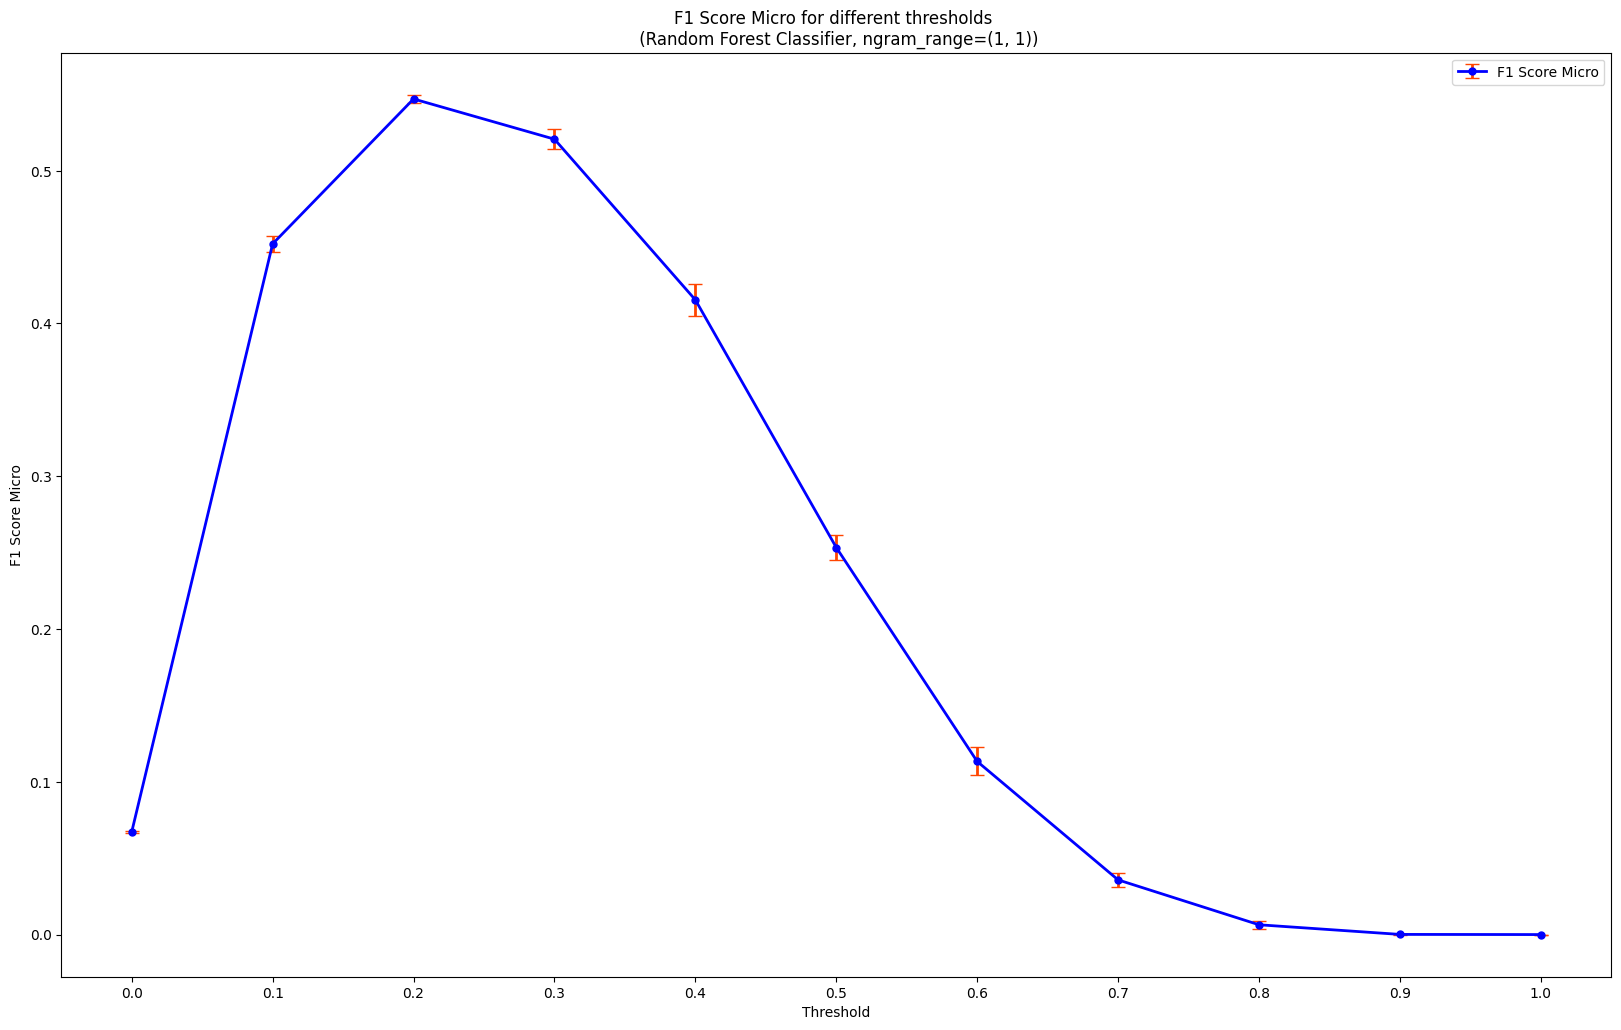

In [12]:
# export results as dataframe
results_to_save = pd.DataFrame.from_dict(results_rfc_ngram_1_1, orient='index').T

# export as csv
results_to_save.to_csv("results/results_rfc_ngram_1_1.csv")

# create a list of thresholds and empty lists for the f1 scores
thresholds = np.linspace(0, 1, 11)
f1_scores_avg = []
f1_scores_std = []

for threshold in thresholds:
    #print(f"running threshold: {threshold}")
    scores = calculate_scores(results_rfc_ngram_1_1, threshold=threshold, f1_metric_type="micro")
    f1_scores_avg.append(scores["average_f1_score"])
    f1_scores_std.append(scores["std_f1_score"])

best_result = {
    "model": "Random Forest Classifier",
    "ngrams": "(1, 1)",
    "highest_f1_score": max(f1_scores_avg),
    "std_deviation": f1_scores_std[f1_scores_avg.index(max(f1_scores_avg))],
    "threshold": thresholds[f1_scores_avg.index(max(f1_scores_avg))]
    }

# create a dataframe
results_df = pd.DataFrame.from_dict(best_result, orient='index').T
display(results_df)

# plot the data with eror bars
plt.figure(figsize=(20, 12))
plt.errorbar(thresholds, f1_scores_avg, yerr=f1_scores_std, fmt='-o', 
             ecolor='orangered', capsize=5, color='blue', markersize=5, 
             linewidth=2, label='F1 Score Micro')
plt.title('F1 Score Micro for different thresholds \n (Random Forest Classifier, ngram_range=(1, 1))')
plt.xlabel('Threshold')
plt.ylabel('F1 Score Micro')

# customize the tick labels
plt.xticks(np.arange(0, 1.1, 0.1))

# add legend
plt.legend(loc='upper right')

# show plot
plt.show()

## 1.9 Random Forest Classifier & n_grams=(1, 2)

Die `perform_classification` erlaubt es uns weiter mit den Hyperparameter wie ngram_range zu spielen. Hier wurde versucht n_gram auf (1, 2) zu erhöhen, in der Hoffnung einen besseren Score zu erreichen. Durch die Erhöhung auf n_gram von (1, 2) dauerte das Trainieren des Machine Learning Modells mit unterschiedlichen Thresholds schwellen Werten noch länger, da das Vokabularmatrix vom Tf-idf deutlich grösser ist verglichen zu n_gram von (1, 1). Gesamthaft dauert das trainieren hier mit diesen Hyperparameter ca. 2 Stunden.
Auch hier können wir eine ähnliche Kurve wie beim Abschnitt 1.8 beobachten. Der beste Threshold liegt bei 0.2 und der beste F1-Micro Score den wir erreichen konnten lag bei 0.54. Verlgeichen wir dies mit dem n_gram von (1, 1) ist der Score um 0.01 tiefer. Wir können somit festhalten, dass die Erhöhung des n_gram von (1, 1) auf (1, 2) keinen grossen Einfluss auf den F1-Micro Score hatte und die Trainingszeit deutlich länger dauerte. Aus diesem Kapitel nehmen wir somit mit, dass je mehr Komplexität dem Machine Learning Modell gegeben wird, sich der Score nicht unbedingt verbessert.

In [13]:
# perform with ngram_range (1, 2)
results_rfc_ngram_1_2 = perform_classification(X=X,
                                      Y=Y,
                                      ngram_range=(1, 2),
                                      estimator=RandomForestClassifier(random_state=42),
                                      n_splits=5,
                                      random_state=42,
                                      verbose=0)

,model,ngrams,highest_f1_score,std_deviation,threshold
0,Random Forest Classifier,"(1, 1)",0.546903,0.002764,0.2
0,Random Forest Classifier,"(1, 2)",0.541613,0.003407,0.2


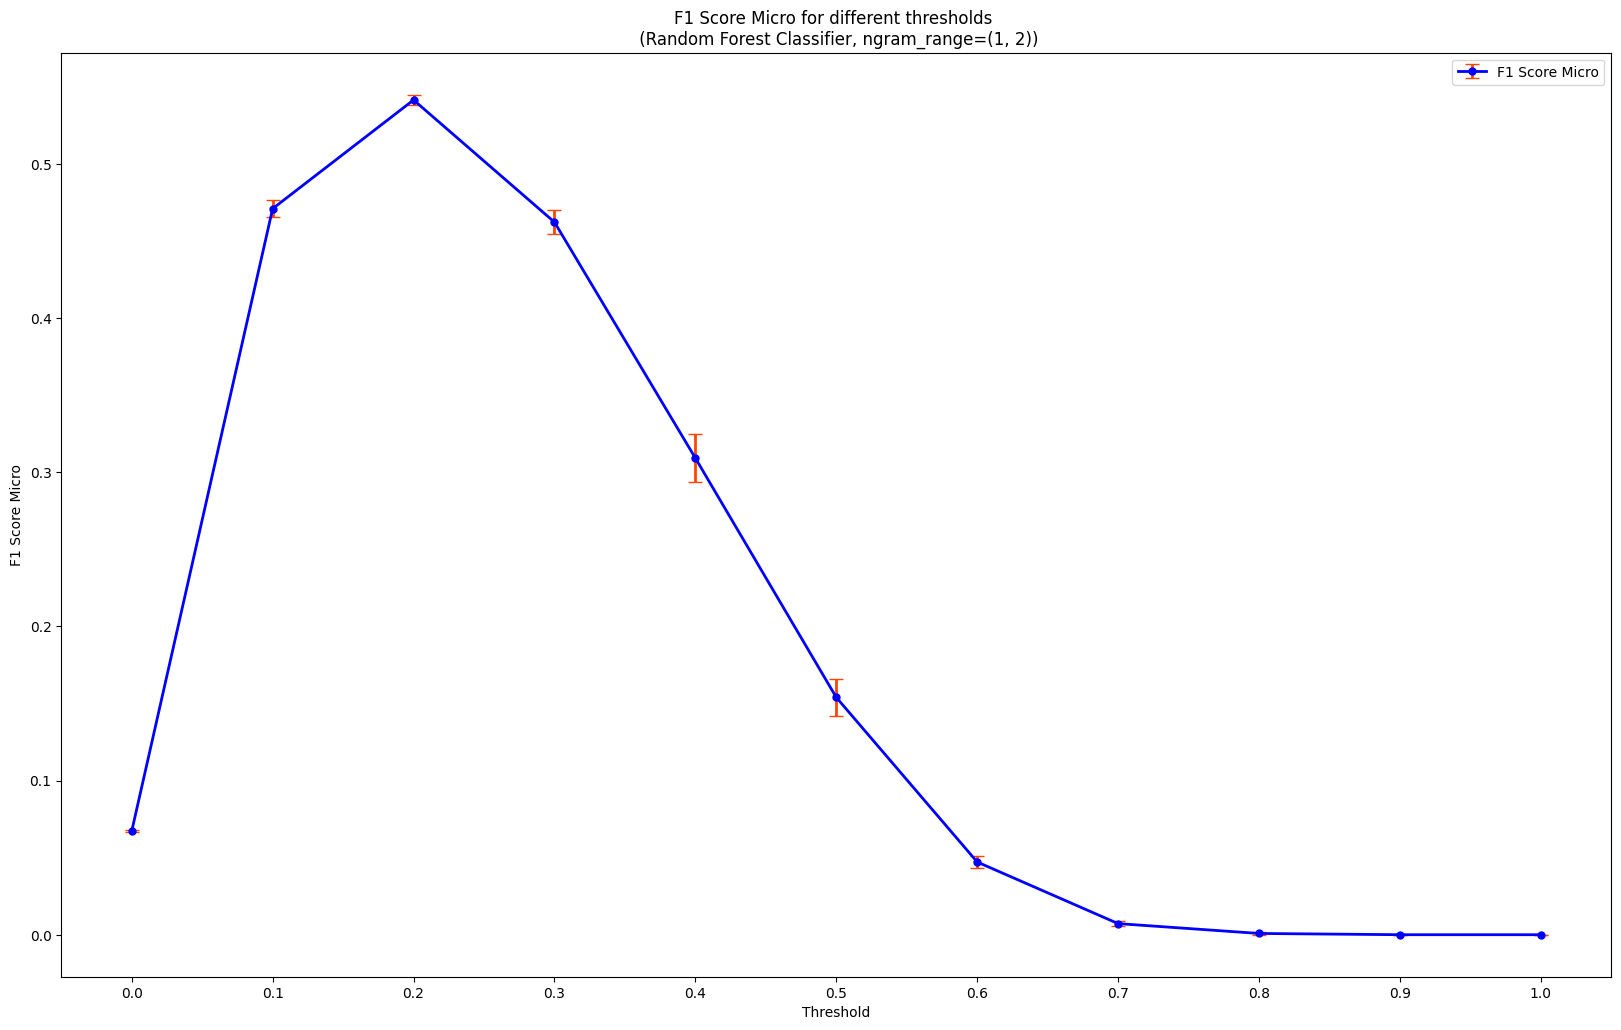

In [14]:
# export results as dataframe
results_to_save = pd.DataFrame.from_dict(results_rfc_ngram_1_2, orient='index').T

# export as csv
results_to_save.to_csv("results/results_rfc_ngram_1_2.csv")


# create a list of thresholds and empty lists for the f1 scores
thresholds = np.linspace(0, 1, 11)
f1_scores_avg = []
f1_scores_std = []

for threshold in thresholds:
    #print(f"running threshold: {threshold}")
    scores = calculate_scores(results_rfc_ngram_1_2, threshold=threshold, f1_metric_type="micro")
    f1_scores_avg.append(scores["average_f1_score"])
    f1_scores_std.append(scores["std_f1_score"])

best_result = {
    "model": "Random Forest Classifier",
    "ngrams": "(1, 2)",
    "highest_f1_score": max(f1_scores_avg),
    "std_deviation": f1_scores_std[f1_scores_avg.index(max(f1_scores_avg))],
    "threshold": thresholds[f1_scores_avg.index(max(f1_scores_avg))]
    }

# concat with previous results dataframe
results_df = pd.concat([results_df, pd.DataFrame.from_dict(best_result, orient='index').T])
display(results_df)

# plot the data with eror bars
plt.figure(figsize=(20, 12))
plt.errorbar(thresholds, f1_scores_avg, yerr=f1_scores_std, fmt='-o', 
             ecolor='orangered', capsize=5, color='blue', markersize=5, 
             linewidth=2, label='F1 Score Micro')
plt.title('F1 Score Micro for different thresholds \n (Random Forest Classifier, ngram_range=(1, 2))')
plt.xlabel('Threshold')
plt.ylabel('F1 Score Micro')

# customize the tick labels
plt.xticks(np.arange(0, 1.1, 0.1))

# add legend
plt.legend(loc='upper right')

# show plot
plt.show()

----
# 2 Deep Learning Model - CNN

## 2.1 Vorgehen

- Trainieren eines eigenen word embeding models
- Durchführen des Word embeding 
- Trainieren verschiedener CNN's
- Testen verschiedener Threasholds
- Evaluirung der Ergebnisse

In [3]:
# imports
import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn_utils
import torch.optim as optim
import torchtext
import gensim
from gensim.models import Word2Vec
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from torch.optim import SGD
from pytorch_lightning import Trainer
import torchmetrics
import pytorch_lightning as pl
import wandb
from pytorch_lightning.loggers import WandbLogger
from collections import Counter
from itertools import chain
from transformers import BertTokenizer, BertForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification

c:\Users\yanni\miniconda3\envs\npr_mc1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Prüfen, ob CUDA verfügbar ist
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda:0


## 2.2 Word embedding

- wesshalb genau Word embedding?

Dimensionalitätsreduktion: Im Gegensatz zu One-Hot-Encoding, bei dem die Vektordimension der Größe des Vokabulars entspricht, haben Word Embeddings eine viel geringere und festgelegte Dimension (z.B. 100, 200). <br>
Semantische Informationen: Embeddings erfassen semantische Informationen und Beziehungen zwischen Wörtern. <br>
Effizienz: Sie verbessern die Effizienz des Lernprozesses, indem sie dem Modell erlauben, schneller und effektiver zu lernen. <br>

- Dabei gibt es 2 wichtige Algorithmen/ Modelle: CBOW und Skip Gram 

In [12]:
class TextDataset(Dataset):
    def __init__(self, descriptions, genres, embedding_model, max_length=1000):
        self.descriptions = descriptions
        self.genres = genres
        self.embedding_model = embedding_model
        self.max_length = max_length 

    def __len__(self):
        return len(self.descriptions)

    def __getitem__(self, idx):
        description = self.descriptions[idx]
        genre = self.genres[idx]

        # Beschränkung der Wörter
        truncated_description = description.split()[:self.max_length]

        # Vektorisieren
        vectorized_text = [self.embedding_model.wv[word] if word in self.embedding_model.wv else [0] * self.embedding_model.vector_size for word in truncated_description]

        # Padding
        padding_length = self.max_length - len(vectorized_text)
        vectorized_text.extend([[0] * self.embedding_model.vector_size] * padding_length)

        text_tensor = torch.FloatTensor(vectorized_text)
        genre_tensor = torch.FloatTensor(genre)

        return text_tensor, genre_tensor

NameError: name 'Dataset' is not defined

In [41]:

# Traineren des eigenen Word2Vec Modells
import_model = True
words_per_vector = 500
batch_size = 50
vector_size = 300

# vector_size: Die Dimension der Word Embeddings
# window: Die maximale Entfernung zwischen dem aktuellen und dem vorhergesagten Wort in einem Satz
# min_count: Das minimale Vorkommen eines Wortes im Corpus, um es zu berücksichtigen
# sg: 0 für das CBOW-Modell, 1 für das Skip-Gram-Modell

if import_model:
    # Load the Word2Vec model
    embedding_model = Word2Vec.load("models/word2vec_modell.bin")

else:
    # Train the Word2Vec model
    embedding_model = Word2Vec(X, vector_size=vector_size, window=5, min_count=1, sg=0)

    # Save the Word2Vec model
    embedding_model.save("word2vec_modell.bin")


# Train Test split
descriptions_train, descriptions_test, genres_train, genres_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Trainings- und Test-Datasets erstellen
train_dataset = TextDataset(descriptions_train, genres_train, embedding_model, max_length=words_per_vector)
test_dataset = TextDataset(descriptions_test, genres_test, embedding_model, max_length=words_per_vector)

# DataLoader für Training und Test
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [14]:
'''# Embedding mit Bert Tokenizer

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# print dimensions of train and test sets in one row
print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)

# get Head of X_train and y_train
print(X_train[:2])
print(y_train[:2])

# BERT Tokenizer Initialisieren
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Encode input X_train and X_test
train_encodings = tokenizer(
    list(X_train),
    truncation=True,
    padding=True,
    max_length=500,
    return_tensors="pt" 
)

test_encodings = tokenizer(
    list(X_test),
    truncation=True,
    padding=True,
    max_length=500,
    return_tensors="pt"
)

# Convert labels to tensors
train_labels = torch.tensor(y_train)
test_labels = torch.tensor(y_test)


# Create dataloaders
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)

train_loader = DataLoader(train_dataset, batch_size=50, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=50, num_workers=0)'''

'# Embedding mit Bert Tokenizer\n\nX_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)\n\n# print dimensions of train and test sets in one row\nprint("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)\nprint("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)\n\n# get Head of X_train and y_train\nprint(X_train[:2])\nprint(y_train[:2])\n\n# BERT Tokenizer Initialisieren\ntokenizer = AutoTokenizer.from_pretrained(\'bert-base-uncased\')\n\n# Encode input X_train and X_test\ntrain_encodings = tokenizer(\n    list(X_train),\n    truncation=True,\n    padding=True,\n    max_length=500,\n    return_tensors="pt" \n)\n\ntest_encodings = tokenizer(\n    list(X_test),\n    truncation=True,\n    padding=True,\n    max_length=500,\n    return_tensors="pt"\n)\n\n# Convert labels to tensors\ntrain_labels = torch.tensor(y_train)\ntest_labels = torch.tensor(y_test)\n\n\n# Create dataloaders\ntrain_dataset = TensorDataset(train_encodings[\'i

## 2.3 Convolutional Neuronal Network (CNN)

In [42]:
# Generelle Modellklasse Eigenes Word2Vec Modell
class CustomLightningModel(pl.LightningModule):
    def __init__(self, lr=0.001, num_classes=57, threshold = 0.2):
        super().__init__()
        self.loss = nn.BCEWithLogitsLoss()
        self.learning_rate = lr
        self.num_classes = num_classes
        self.fbeta = torchmetrics.FBetaScore(num_labels=num_classes, beta=1.0, average='micro', task='multilabel')

    def _log(self, status, y_hat, y):
        loss = self.loss(y_hat, y)
        y_hat_labels = (y_hat.sigmoid() > threshold).float()
        fbeta_score = self.fbeta(y_hat_labels, y)
        self.log(f'{status}_loss', loss)
        self.log(f'{status}_f1_mikro', fbeta_score, prog_bar=True)
        return loss

    def forward(self, x):
        x = x.permute(0, 2, 1)
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        return self._log('train', y_hat, y)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        return self._log('val', y_hat, y)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        return self._log('test', y_hat, y)

    def configure_optimizers(self):
        return SGD(self.parameters(), lr=self.learning_rate)

In [43]:
def evaluate_model(model, dataloader, threshold):
    model.eval()

    all_predictions = []
    all_labels = []

    with torch.no_grad(): 
        for texts, labels in dataloader:
            outputs = model(texts)
            predictions = torch.sigmoid(outputs)
            # Thresholding
            predictions = (predictions > threshold).float()

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Berechnen der Metriken
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='micro')
    recall = recall_score(all_labels, all_predictions, average='micro')
    f1_mikro = f1_score(all_labels, all_predictions, average='micro')
    f1_makro = f1_score(all_labels, all_predictions, average='macro')

    return accuracy, precision, recall, f1_mikro, f1_makro

In [44]:
def test_thresholds(model, dataloader, thresholds):
    results = []
    for threshold in thresholds:
        accuracy, precision, recall, f1_mikro, f1_makro = evaluate_model(model, dataloader, threshold)
        results.append({
            'threshold': threshold,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_mikro': f1_mikro,
            'f1_makro': f1_makro,
        })

    # Erstellen eines DataFrames aus den Ergebnissen
    df = pd.DataFrame(results)

    # Anzeigen des DataFrames
    print(df)

    # Ermitteln des besten Thresholds basierend auf dem höchsten f1_mikro Wert
    best_threshold = df.loc[df['f1_mikro'].idxmax(), 'threshold']

    return df, best_threshold

# Testen der Funktion mit den gegebenen Thresholds
thresholds = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [45]:
def k_fold_cross_validation(model_class, k_folds, lr, num_classes, dropout_rate, batch_size, train_data, test_data):
    all_results = []

    kfold = KFold(n_splits=k_folds, shuffle=True)

    for fold, (train_ids, val_ids) in enumerate(kfold.split(train_data)):
        print(f"Folding {fold+1}/{k_folds}")

        # Teilen des Trainingsdatensatzes in aktuelle Trainings- und Validierungsdatensätze
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

        train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_subsampler)
        val_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=val_subsampler)

        # Instanziieren des Modells für den aktuellen Fold
        model = model_class(lr=lr, num_classes=num_classes, dropout_rate=dropout_rate)

        trainer = pl.Trainer(max_epochs=1)
        
        # Trainieren des Modells
        trainer.fit(model, train_loader, val_loader)

        # Testen des Modells
        result = trainer.test(dataloaders=test_loader)
        result_dict = {'fold': fold}
        result_dict.update(result[0])
        all_results.append(result_dict)

    # Speichern der Ergebnisse in einer CSV-Datei
    results_df = pd.DataFrame(all_results)
    results_df.to_csv('results/cross_validation_results_simple_cnn.csv', index=False)

    return results_df


## 2.4 Simple CNN

In [19]:
class SimpleCNN(CustomLightningModel):
    def __init__(self, lr=0.001, num_classes=57, dropout_rate=0.25):
        super().__init__(lr, num_classes)
        final_feature_size = 16*500  
        self.model = nn.Sequential(
            nn.Conv1d(in_channels=vector_size, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(final_feature_size, 50),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(50, self.num_classes) 
        ).to(device)

In [21]:
# Simple CNN with CV
train_data = train_dataset
test_data = test_dataset

# Hyperparameter
k_folds = 5
batch_size = batch_size 
learning_rate = 0.001
num_classes = 57
dropout_rate = 0.25

results = k_fold_cross_validation(SimpleCNN, k_folds, learning_rate, num_classes, dropout_rate, batch_size, train_data, test_data)

'''# Ergebnisse für jeden Fold ausgeben
for fold, result in enumerate(results):
    print(f"Ergebnisse für Fold {fold}: {result}")
'''

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type                 | Params
-----------------------------------------------
0 | loss  | BCEWithLogitsLoss    | 0     
1 | fbeta | MultilabelFBetaScore | 0     
2 | model | Sequential           | 472 K 
-----------------------------------------------
472 K     Trainable params
0         Non-trainable params
472 K     Total params
1.892     Total estimated model params size (MB)


Folding 1/5
Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0: 100%|██████████| 127/127 [03:36<00:00,  0.59it/s, v_num=1, train_f1_mikro=0.0704, val_f1_mikro=0.0666]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 127/127 [03:36<00:00,  0.59it/s, v_num=1, train_f1_mikro=0.0704, val_f1_mikro=0.0666]

c:\Users\yanni\OneDrive\FHNW\Module\5. Semester\Natural language processing\fhnw-npr-Natural-Language-Processing\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at c:\Users\yanni\OneDrive\FHNW\Module\5. Semester\Natural language processing\fhnw-npr-Natural-Language-Processing\mini-challenge1\lightning_logs\version_1\checkpoints\epoch=0-step=127.ckpt
Loaded model weights from the checkpoint at c:\Users\yanni\OneDrive\FHNW\Module\5. Semester\Natural language processing\fhnw-npr-Natural-Language-Processing\mini-challenge1\lightning_logs\version_1\checkpoints\epoch=0-step=127.ckpt
c:\Users\yanni\OneDrive\FHNW\Module\5. Semester\Natural lan


Testing DataLoader 0: 100%|██████████| 99/99 [01:07<00:00,  1.47it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type                 | Params
-----------------------------------------------
0 | loss  | BCEWithLogitsLoss    | 0     
1 | fbeta | MultilabelFBetaScore | 0     
2 | model | Sequential           | 472 K 
-----------------------------------------------
472 K     Trainable params
0         Non-trainable params
472 K     Total params
1.892     Total estimated model params size (MB)



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_f1_mikro         0.06628228724002838
        test_loss           0.7021142840385437
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Folding 2/5
Epoch 0: 100%|██████████| 127/127 [03:59<00:00,  0.53it/s, v_num=2, train_f1_mikro=0.0795, val_f1_mikro=0.0677]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 127/127 [03:59<00:00,  0.53it/s, v_num=2, train_f1_mikro=0.0795, val_f1_mikro=0.0677]

Restoring states from the checkpoint path at c:\Users\yanni\OneDrive\FHNW\Module\5. Semester\Natural language processing\fhnw-npr-Natural-Language-Processing\mini-challenge1\lightning_logs\version_2\checkpoints\epoch=0-step=127.ckpt
Loaded model weights from the checkpoint at c:\Users\yanni\OneDrive\FHNW\Module\5. Semester\Natural language processing\fhnw-npr-Natural-Language-Processing\mini-challenge1\lightning_logs\version_2\checkpoints\epoch=0-step=127.ckpt



Testing DataLoader 0: 100%|██████████| 99/99 [01:02<00:00,  1.59it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type                 | Params
-----------------------------------------------
0 | loss  | BCEWithLogitsLoss    | 0     
1 | fbeta | MultilabelFBetaScore | 0     
2 | model | Sequential           | 472 K 
-----------------------------------------------
472 K     Trainable params
0         Non-trainable params
472 K     Total params
1.892     Total estimated model params size (MB)



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_f1_mikro         0.06628228724002838
        test_loss           0.6945494413375854
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Folding 3/5
Epoch 0: 100%|██████████| 127/127 [03:40<00:00,  0.58it/s, v_num=3, train_f1_mikro=0.0602, val_f1_mikro=0.0677]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 127/127 [03:40<00:00,  0.58it/s, v_num=3, train_f1_mikro=0.0602, val_f1_mikro=0.0677]

Restoring states from the checkpoint path at c:\Users\yanni\OneDrive\FHNW\Module\5. Semester\Natural language processing\fhnw-npr-Natural-Language-Processing\mini-challenge1\lightning_logs\version_3\checkpoints\epoch=0-step=127.ckpt
Loaded model weights from the checkpoint at c:\Users\yanni\OneDrive\FHNW\Module\5. Semester\Natural language processing\fhnw-npr-Natural-Language-Processing\mini-challenge1\lightning_logs\version_3\checkpoints\epoch=0-step=127.ckpt



Testing DataLoader 0: 100%|██████████| 99/99 [01:07<00:00,  1.47it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type                 | Params
-----------------------------------------------
0 | loss  | BCEWithLogitsLoss    | 0     
1 | fbeta | MultilabelFBetaScore | 0     
2 | model | Sequential           | 472 K 
-----------------------------------------------
472 K     Trainable params
0         Non-trainable params
472 K     Total params
1.892     Total estimated model params size (MB)



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_f1_mikro         0.06628228724002838
        test_loss           0.6867742538452148
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Folding 4/5
Epoch 0: 100%|██████████| 127/127 [03:54<00:00,  0.54it/s, v_num=4, train_f1_mikro=0.064, val_f1_mikro=0.0671]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 127/127 [03:54<00:00,  0.54it/s, v_num=4, train_f1_mikro=0.064, val_f1_mikro=0.0671]

Restoring states from the checkpoint path at c:\Users\yanni\OneDrive\FHNW\Module\5. Semester\Natural language processing\fhnw-npr-Natural-Language-Processing\mini-challenge1\lightning_logs\version_4\checkpoints\epoch=0-step=127.ckpt
Loaded model weights from the checkpoint at c:\Users\yanni\OneDrive\FHNW\Module\5. Semester\Natural language processing\fhnw-npr-Natural-Language-Processing\mini-challenge1\lightning_logs\version_4\checkpoints\epoch=0-step=127.ckpt



Testing DataLoader 0: 100%|██████████| 99/99 [01:02<00:00,  1.57it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type                 | Params
-----------------------------------------------
0 | loss  | BCEWithLogitsLoss    | 0     
1 | fbeta | MultilabelFBetaScore | 0     
2 | model | Sequential           | 472 K 
-----------------------------------------------
472 K     Trainable params
0         Non-trainable params
472 K     Total params
1.892     Total estimated model params size (MB)



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_f1_mikro         0.06628228724002838
        test_loss           0.6989849805831909
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Folding 5/5
Epoch 0: 100%|██████████| 127/127 [04:04<00:00,  0.52it/s, v_num=5, train_f1_mikro=0.0703, val_f1_mikro=0.0679]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 127/127 [04:04<00:00,  0.52it/s, v_num=5, train_f1_mikro=0.0703, val_f1_mikro=0.0679]

Restoring states from the checkpoint path at c:\Users\yanni\OneDrive\FHNW\Module\5. Semester\Natural language processing\fhnw-npr-Natural-Language-Processing\mini-challenge1\lightning_logs\version_5\checkpoints\epoch=0-step=127.ckpt
Loaded model weights from the checkpoint at c:\Users\yanni\OneDrive\FHNW\Module\5. Semester\Natural language processing\fhnw-npr-Natural-Language-Processing\mini-challenge1\lightning_logs\version_5\checkpoints\epoch=0-step=127.ckpt



Testing DataLoader 0: 100%|██████████| 99/99 [01:03<00:00,  1.55it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_f1_mikro         0.06628228724002838
        test_loss           0.6952707171440125
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Ergebnisse für Fold 0: fold
Ergebnisse für Fold 1: test_loss
Ergebnisse für Fold 2: test_f1_mikro


In [20]:
# Instanziieren Sie Ihr Modell
simpleCNN = SimpleCNN(lr=0.001, num_classes=57, dropout_rate=0.25)

wandb_logger = WandbLogger(name="SimpleCNN_Training_words500_batchsize50", project="NPR_MC1")
trainer = pl.Trainer(max_epochs=10, logger=wandb_logger, gpus=1 if torch.cuda.is_available() else 0)
trainer.fit(simpleCNN, train_loader.to(device), test_loader.to(device))

wandb_logger.experiment.finish()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: yannic-lais (krokodil). Use `wandb login --relogin` to force relogin



  | Name  | Type                 | Params
-----------------------------------------------
0 | loss  | BCEWithLogitsLoss    | 0     
1 | fbeta | MultilabelFBetaScore | 0     
2 | model | Sequential           | 472 K 
-----------------------------------------------
472 K     Trainable params
0         Non-trainable params
472 K     Total params
1.892     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\yanni\OneDrive\FHNW\Module\5. Semester\Natural language processing\fhnw-npr-Natural-Language-Processing\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\Users\yanni\AppData\Local\Temp\ipykernel_7364\1579048374.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  text_tensor = torch.FloatTensor(vectorized_text)


c:\Users\yanni\OneDrive\FHNW\Module\5. Semester\Natural language processing\fhnw-npr-Natural-Language-Processing\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 396/396 [05:30<00:00,  1.20it/s, v_num=kxw2, train_f1_mikro=0.0725, val_f1_mikro=0.0663]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 396/396 [05:30<00:00,  1.20it/s, v_num=kxw2, train_f1_mikro=0.0725, val_f1_mikro=0.0663]


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_f1_mikro,▇▅▄▇█▅▇▅▅▅▃▅▁▃▆▇█▅▅▇█▅█▇█▇▇▄▅▅▅▄▅▃▅▇▄▄█▆
train_loss,█████▇▇▇▇▇▇▇▇▆▇▆▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▂▃▂▂▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_f1_mikro,▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▇▆▅▅▄▂▁
epoch,9
train_f1_mikro,0.07107
train_loss,0.6481
trainer/global_step,3959
val_f1_mikro,0.06628


In [46]:
results_df_simpleCNN, best_threshold_simpleCNN = test_thresholds(simpleCNN, test_loader, thresholds)

# Anzeigen des besten Thresholds
print("Bester Threshold:", best_threshold_simpleCNN)

c:\Users\yanni\OneDrive\FHNW\Module\5. Semester\Natural language processing\fhnw-npr-Natural-Language-Processing\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\yanni\OneDrive\FHNW\Module\5. Semester\Natural language processing\fhnw-npr-Natural-Language-Processing\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\yanni\OneDrive\FHNW\Module\5. Semester\Natural language processing\fhnw-npr-Natural-Language-Processing\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetri

    threshold  accuracy  precision    recall  f1_mikro  f1_makro
0        0.05       0.0   0.034298  1.000000  0.066321  0.058231
1        0.10       0.0   0.034298  1.000000  0.066321  0.058231
2        0.15       0.0   0.034298  1.000000  0.066321  0.058231
3        0.20       0.0   0.034298  1.000000  0.066321  0.058231
4        0.25       0.0   0.034298  1.000000  0.066321  0.058231
5        0.30       0.0   0.034298  1.000000  0.066321  0.058231
6        0.40       0.0   0.034569  0.990168  0.066806  0.057570
7        0.50       0.0   0.029950  0.245278  0.053381  0.015721
8        0.60       0.0   0.000000  0.000000  0.000000  0.000000
9        0.70       0.0   0.000000  0.000000  0.000000  0.000000
10       0.80       0.0   0.000000  0.000000  0.000000  0.000000
11       0.90       0.0   0.000000  0.000000  0.000000  0.000000
Bester Threshold: 0.4


c:\Users\yanni\OneDrive\FHNW\Module\5. Semester\Natural language processing\fhnw-npr-Natural-Language-Processing\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\yanni\OneDrive\FHNW\Module\5. Semester\Natural language processing\fhnw-npr-Natural-Language-Processing\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [47]:
# calculate metrics for best threshold
results_df = results_df_simpleCNN[results_df_simpleCNN['threshold'] == best_threshold_simpleCNN]
# append new column with model name
results_df['model'] = "Simple CNN"

C:\Users\yanni\AppData\Local\Temp\ipykernel_7364\4095007335.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df['model'] = "Simple CNN"


In [26]:
torch.save(simpleCNN.state_dict(), 'models/simple_CNN_model.pth')

## 2.5 Complex CNN

In [48]:
class ComplexCNN(CustomLightningModel):
    def __init__(self, lr=0.001, num_classes=57, dropout_rate=0.25):
        super().__init__(lr, num_classes)

        # Spezifikationen
        batch_size = batch_size
        num_vectors = words_per_vector
        vector_size = vector_size

        # Initialisieren Sie die Größe der Eingabe
        input_size = (batch_size, num_vectors, vector_size)
        final_feature_size = 256*125 

        self.model = nn.Sequential(
            nn.Conv1d(in_channels=input_size[2], out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate),
            nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate),
            nn.Flatten(),
            nn.Linear(final_feature_size, batch_size), 
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(batch_size, self.num_classes) 
        )

In [53]:
# Instanziieren Sie Ihr Modell
complexCNN = ComplexCNN(lr=0.001, num_classes=57)

wandb_logger = WandbLogger(name="ComplexCNN_Training_500words_50batches", project="NPR_MC1")
trainer = pl.Trainer(max_epochs=15, logger=wandb_logger)
trainer.fit(complexCNN, train_loader, test_loader)

wandb_logger.experiment.finish()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\yanni\OneDrive\FHNW\Module\5. Semester\Natural language processing\fhnw-npr-Natural-Language-Processing\.venv\Lib\site-packages\pytorch_lightning\loggers\wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

  | Name  | Type                 | Params
-----------------------------------------------
0 | loss  | BCEWithLogitsLoss    | 0     
1 | fbeta | MultilabelFBetaScore | 0     
2 | model | Sequential           | 2.0 M 
-----------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.923     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\yanni\OneDrive\FHNW\Module\5. Semester\Natural language processing\fhnw-npr-Natural-Language-Processing\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

NameError: name 'threshold' is not defined

In [29]:
results_df_complexCNN, best_threshold_complexCNN = test_thresholds(complexCNN, test_loader, thresholds)

# Anzeigen des besten Thresholds
print("Bester Threshold:", best_threshold_complexCNN)

c:\Users\yanni\OneDrive\FHNW\Module\5. Semester\Natural language processing\fhnw-npr-Natural-Language-Processing\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\yanni\OneDrive\FHNW\Module\5. Semester\Natural language processing\fhnw-npr-Natural-Language-Processing\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\yanni\OneDrive\FHNW\Module\5. Semester\Natural language processing\fhnw-npr-Natural-Language-Processing\.venv\Lib\site-packages\sklearn\metrics\_classi

    threshold  accuracy  precision    recall  f1_mikro  f1_makro
0        0.10  0.000000   0.052006  0.797671  0.097645  0.045045
1        0.15  0.000000   0.047155  0.481759  0.085901  0.026586
2        0.20  0.000000   0.041792  0.277878  0.072656  0.015436
3        0.25  0.000000   0.072549  0.259767  0.113421  0.014210
4        0.30  0.000000   0.101366  0.259250  0.145745  0.014175
5        0.40  0.000000   0.166414  0.255369  0.201511  0.013910
6        0.50  0.003541   0.248356  0.254075  0.251183  0.013821
7        0.60  0.000000   0.000000  0.000000  0.000000  0.000000
8        0.70  0.000000   0.000000  0.000000  0.000000  0.000000
9        0.80  0.000000   0.000000  0.000000  0.000000  0.000000
10       0.90  0.000000   0.000000  0.000000  0.000000  0.000000
Bester Threshold: 0.5


c:\Users\yanni\OneDrive\FHNW\Module\5. Semester\Natural language processing\fhnw-npr-Natural-Language-Processing\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\yanni\OneDrive\FHNW\Module\5. Semester\Natural language processing\fhnw-npr-Natural-Language-Processing\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [ ]:
# append bestthreashold to dataframe with model name
best_threshold_df_complex = results_df_complexCNN[results_df_complexCNN['threshold'] == best_threshold_complexCNN]
best_threshold_df_complex['model'] = "Complex CNN"

# concat with previous results dataframe
results_df = pd.concat([results_df, best_threshold_df_complex])

C:\Users\yanni\AppData\Local\Temp\ipykernel_1860\3000614559.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_threshold_df_complex['model'] = "Complex CNN"


In [ ]:
torch.save(complexCNN.state_dict(), 'models/complex_CNN_model_500words_50batches.pth')

## 2.6 Deep Complex CNN

Wir trainieren ein zusätzliches tiefes, jedoch schmales CNN aufgrund der Sequentiellen Textdaten. <br>
Textdaten sind von Natur aus sequentiell und kontextabhängig. Tiefere Netzwerke sind in der Regel besser darin, langfristige Abhängigkeiten und komplexe Muster in Sequenzdaten zu erfassen.

In [36]:
class DeepCNN(CustomLightningModel):
    def __init__(self, lr=0.001, num_classes=57, dropout_rate=0.25):
        super().__init__(lr, num_classes)

        # Spezifikationen
        batch_size = batch_size
        num_vectors = words_per_vector
        vector_size = vector_size

        # Initialisieren Sie die Größe der Eingabe
        input_size = (batch_size, num_vectors, vector_size)
        final_feature_size = 64*62.5 

        self.model = nn.Sequential(
            nn.Conv1d(in_channels=input_size[2], out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate),
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(dropout_rate),
            nn.Flatten(),
            nn.Linear(final_feature_size, batch_size), 
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(batch_size, self.num_classes) 
        )

In [38]:
# Instanziieren Sie Ihr Modell
deepCNN = DeepCNN(lr=0.001, num_classes=57)

wandb_logger = WandbLogger(name="deepCNN_Training_500words_50batches", project="NPR_MC1")
trainer = pl.Trainer(max_epochs=10, logger=wandb_logger)
trainer.fit(deepCNN, train_loader, test_loader)

wandb_logger.experiment.finish()

TypeError: empty(): argument 'size' failed to unpack the object at pos 2 with error "type must be tuple of ints,but got float"

In [34]:
results_df_deepCNN, best_threshold_deepCNN = test_thresholds(deepCNN, test_loader, thresholds)

# Anzeigen des besten Thresholds
print("Bester Threshold:", best_threshold_deepCNN)

c:\Users\yanni\OneDrive\FHNW\Module\5. Semester\Natural language processing\fhnw-npr-Natural-Language-Processing\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\yanni\OneDrive\FHNW\Module\5. Semester\Natural language processing\fhnw-npr-Natural-Language-Processing\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\yanni\OneDrive\FHNW\Module\5. Semester\Natural language processing\fhnw-npr-Natural-Language-Processing\.venv\Lib\site-packages\sklearn\metrics\_classi

    threshold  accuracy  precision    recall  f1_mikro  f1_makro
0        0.10  0.000000   0.034298  1.000000  0.066321  0.058231
1        0.15  0.000000   0.034298  1.000000  0.066321  0.058231
2        0.20  0.000000   0.034856  0.998448  0.067361  0.058124
3        0.25  0.000000   0.037596  0.942303  0.072308  0.054433
4        0.30  0.000000   0.033981  0.677878  0.064717  0.038617
5        0.40  0.000000   0.034294  0.350841  0.062481  0.019861
6        0.50  0.000000   0.022256  0.182147  0.039665  0.010879
7        0.60  0.000000   0.048862  0.124968  0.070255  0.007109
8        0.70  0.001517   0.012645  0.006468  0.008559  0.000438
9        0.80  0.000000   0.000000  0.000000  0.000000  0.000000
10       0.90  0.000000   0.000000  0.000000  0.000000  0.000000
Bester Threshold: 0.25


c:\Users\yanni\OneDrive\FHNW\Module\5. Semester\Natural language processing\fhnw-npr-Natural-Language-Processing\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\yanni\OneDrive\FHNW\Module\5. Semester\Natural language processing\fhnw-npr-Natural-Language-Processing\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [35]:
# append bestthreashold to dataframe with model name
best_threshold_df_deep = results_df_deepCNN[results_df_deepCNN['threshold'] == best_threshold_deepCNN]
best_threshold_df_deep['model'] = "Deep CNN"

# concat with previous results dataframe
results_df = pd.concat([results_df, best_threshold_df_deep])

C:\Users\yanni\AppData\Local\Temp\ipykernel_1860\318981671.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_threshold_df_deep['model'] = "Deep CNN"


In [36]:
torch.save(deepCNN.state_dict(), 'models/deep_CNN_model_2000_words.pth')

In [26]:
# save results as csv
results_df.to_csv("results/results_cnn_V2Vembedding_words500_batchsize50.csv")

## 2.7 Evaluation

In [27]:
results_df = pd.read_csv("results/results_cnn_V2Vembedding_words500_batchsize50.csv")

NameError: name 'results_df_complexCNN' is not defined

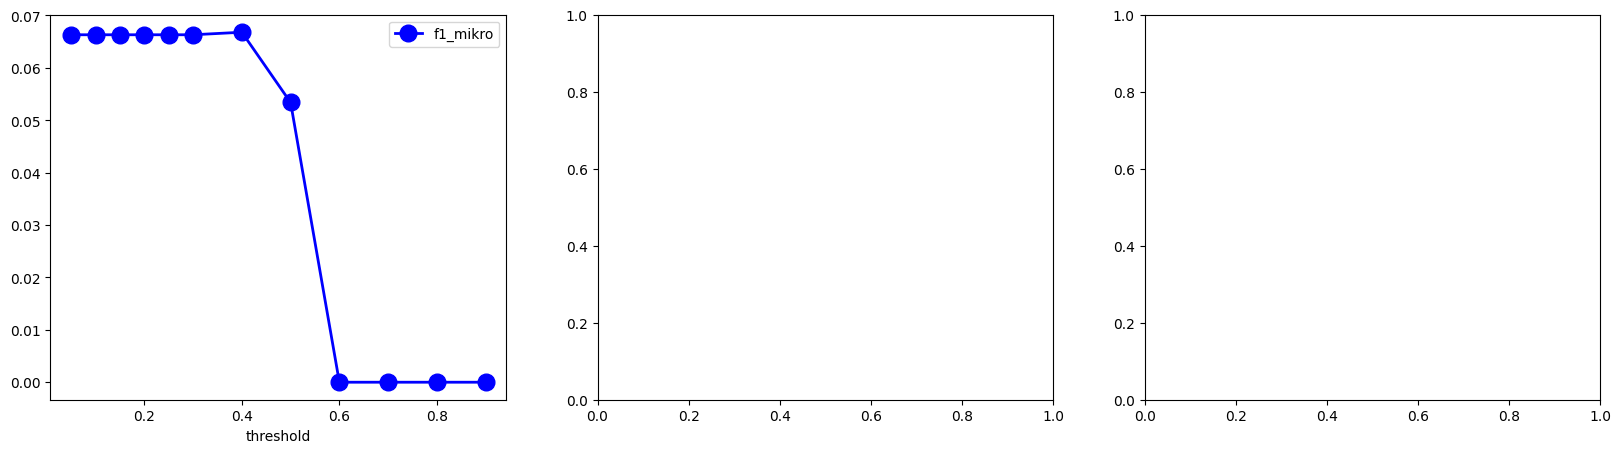

In [28]:
# make a plot with 3 subplots with the f1_mikro scores for each model and eaach threshold
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# plot the data with eror bars
results_df_simpleCNN.plot(x='threshold', y='f1_mikro', ax=axes[0], marker='o', color='blue', linewidth=2, markersize=12)
results_df_complexCNN.plot(x='threshold', y='f1_mikro', ax=axes[1], marker='o', color='blue', linewidth=2, markersize=12)
results_df_deepCNN.plot(x='threshold', y='f1_mikro', ax=axes[2], marker='o', color='blue', linewidth=2, markersize=12)

# add labels
axes[0].set_title('Simple CNN')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('F1 Score Micro')

axes[1].set_title('Complex CNN')
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('F1 Score Micro')

axes[2].set_title('Deep CNN')
axes[2].set_xlabel('Threshold')
axes[2].set_ylabel('F1 Score Micro')

# customize the tick labels
axes[0].set_xticks(np.arange(0, 1.1, 0.1))
axes[1].set_xticks(np.arange(0, 1.1, 0.1))
axes[2].set_xticks(np.arange(0, 1.1, 0.1))

plt.show()

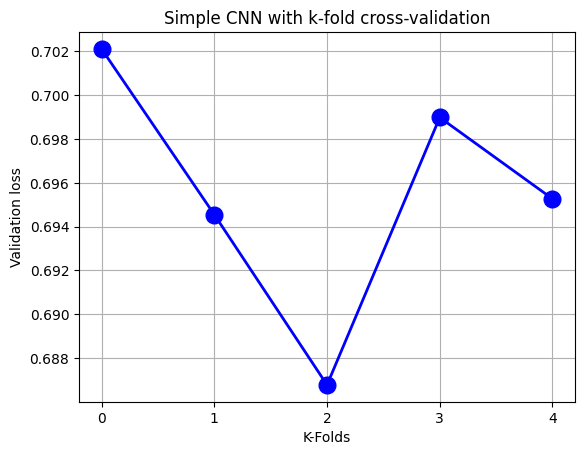

In [32]:
# Laden der Ergebnisse aus der CSV-Datei
results_df = pd.read_csv('cross_validation_results_simple_cnn.csv')

# unique x axis values
x_values = results_df['fold'].unique()

# Plotten der Ergebnisse
plt.plot(results_df['fold'], results_df['test_loss'], marker='o', color='blue', linewidth=2, markersize=12)
plt.xlabel('K-Folds')
plt.ylabel('Validation loss')
plt.title('Simple CNN with k-fold cross-validation')
plt.xticks(x_values)
plt.grid(True)
plt.show()

----
# 3 Deep Learning Model - Transformers

Wir versuchen eine Genre-Klassifkation mit einem Deep Learning Model zu erreichen. Dazu verwenden wir ein BERT Model, welches wir mit der Huggingface Library einlesen.

## 3.1 Setup

Damit das Deep Learning Modell trainiert werden kann, imporieren wir hier die wichtigen Libraries und überprüfen, die Version von PyTorch.

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch
print(torch.__version__)

from sklearn.metrics import jaccard_score
from transformers import DataCollatorWithPadding, Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification, AutoTokenizer

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import BCEWithLogitsLoss

import torch
from torch.nn import Sigmoid

import random

from tqdm import tqdm                                        


1.13.1+cu116


In [ ]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

# Set the seed value all over the place to make this reproducible.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)



Using device: cuda

NVIDIA GeForce GTX 980
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


## 3.2 Data PreProcessing

Damit wir mit dem Bert Transformer arbeiten können, müssen wir zuerst unsere Daten in ein passendes Format für den Bert Classifier bringen. Dazu gehört, dass wir unsere X_train und X_test Input jeweils tokensieren und auf eine länge von 512 Tokens verarbeiten. Falls eine Zusammenfassung weniger als 512 Tokens hat, so wird diese mit padding aufgefüllt. Bei längeren Zusammenfassungen werden diese auf 512 Tokens geschnitten. 


Folgende Parameter wurden von bert_tokenizer verwendet:   

`list(X_train)/list(X_test)`:   
Wandelt die Daten in eine Liste von Texten um, die tokenisiert werden sollen. Der Tokenizer verarbeitet diese Listen und erstellt die Token für jedes Element.

`truncation=True`:   
Dieser Parameter gibt an, dass alle Texte, die länger als die maximale Länge (max_length) sind, abgeschnitten werden sollen. Das bedeutet, dass Teile des Textes am Ende entfernt werden, um die maximale Länge einzuhalten.

`padding=True`:   
Stellt sicher, dass alle tokenisierten Ausgaben die gleiche Länge haben, indem sie mit Nullen (oder einem anderen spezifizierten Token) aufgefüllt werden, bis sie die maximale Länge erreichen. Dies ist notwendig, da Modelle wie BERT Eingaben erfordern, die in der Größe einheitlich sind.

`max_length=512`:   
Legt die maximale Sequenzlänge fest. Da BERT-Modelle auf eine bestimmte maximale Eingabelänge beschränkt sind (oft 512 Token), stellt dieser Parameter sicher, dass keine Eingabe diese Grenze überschreitet.

`return_tensors="pt"`:   
Hiermit wird festgelegt, dass der Tokenizer die tokenisierten Daten direkt als PyTorch-Tensoren (pt) zurückgeben soll, was den zusätzlichen Schritt des manuellen Umwandelns in Tensoren überflüssig macht. Alternativ könnten Sie return_tensors="tf" für TensorFlow-Tensoren oder return_tensors="np" für NumPy-Arrays verwenden, je nachdem, mit welchem Framework Sie arbeiten.

Diese Parameter helfen dabei, die Daten für das Training mit BERT oder einem anderen Transformer-Modell vorzubereiten. Sie sorgen für die nötige Konsistenz und Formatierung, die für das effektive Training und die Vorhersage erforderlich sind.

In [ ]:
# Splitting X and Y
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# print dimensions of train and test sets in one row
print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)

# get Head of X_train and y_train
print(X_train[:2])
print(y_train[:2])



X_train shape: (7907,) y_train shape: (7907, 57)
X_test shape: (1977,) y_test shape: (1977, 57)
['alien spacecraft arrives earth contact established two people begin learn frank nobilio science advisor american president cletus calhoun tennessee hillbilly popularizer science somewhat like carl sagan two main ambassador alien call tosoks tosoks explain ship damaged kuiper belt initial attempted repair one eight tosoks died assured human provide build tool necessary fix take two year thing go well year tosoks taking tour major civilized country earth view impressed august 11 1999 total solar eclipse cletus calhoun found dead circumstance place one alien hask suspicion calhoun bled death leg completely severed tool unknown human forensic pathologist also jaw one eye spleen removed never found hask appears police investigating tosok fashion shedded skin speculated order hide telltale blood splatter hask arrested murder remainder novel concern hasks trial los angeles california court hask m

In [ ]:
# BERT Tokenizer Initialisieren
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
# Initialize BERT model
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=57)

# Encode input X_train and X_test
train_encodings = tokenizer(
    list(X_train),
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors="pt" 
)

test_encodings = tokenizer(
    list(X_test),
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors="pt"
)

# Convert labels to tensors
train_labels = torch.tensor(y_train)
test_labels = torch.tensor(y_test)


# Create dataloaders
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)

train_loader = DataLoader(train_dataset, batch_size=2, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=2, num_workers=0)



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 3.3 Check Batch Size

Damit wir keine Probleme mit dem Speicherplatz von der GPU haben, checken wir hier die grösse eines Batches.   
Ein Batch hat in unserem Fall mit batch_size von 2, 0.02 MB. 

In [ ]:
# Assuming you have a DataLoader instance named `data_loader`
data_iter = iter(train_loader)
first_batch = next(data_iter)

# Calculate memory usage
def get_tensor_size(tensor):
    return tensor.element_size() * tensor.nelement()

batch_memory_size = 0
for tensor in first_batch:
    # Ensure we're dealing with a PyTorch tensor
    if torch.is_tensor(tensor):
        batch_memory_size += get_tensor_size(tensor)
    # Handle case where data might be in a list or a tuple
    elif isinstance(tensor, (list, tuple)):
        for item in tensor:
            if torch.is_tensor(item):
                batch_memory_size += get_tensor_size(item)

# Convert to megabytes
batch_memory_size_mb = batch_memory_size / (1024 ** 2)
print(f'Memory size of one batch: {batch_memory_size_mb:.2f} MB')

Memory size of one batch: 0.02 MB


## 3.4 Moving to GPU

Hier in diesem Abschnitt bewegen wir alle unsere Tensoren auf die GPU. Dies ist notwendig, da wir sonst nicht mit dem Bert Model arbeiten können.

In [ ]:

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce GTX 980
Memory Usage:
Allocated: 0.4 GB
Cached:    0.5 GB


## 3.5 Model Training

Hier fine-tunen wir unser Modell, indem wir die Anzahl der Epochen auf 5 definieren und die Learning rate auf 0.00001.   
Diese Hyperparameter können natürlich noch weiter optimiert werden. In unserem Fall fixieren wir die Hyperparamter und schauen uns zuerst einmal an, ob das Modell überhaupt unseren Datensatz lernt und klassifizieren kann. 

In [ ]:
# Training settings
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-5)
loss_fn = BCEWithLogitsLoss()

num_epochs = 5

loss_list = []

# training loop
model.train()
for epoch in range(num_epochs):
    # Wrap train_loader with tqdm for a progress bar
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        # Unpack batch and move to GPU
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels.float())
        # append loss to loss_list
        loss_list.append(loss.item())

        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

# Save the model after training
model.save_pretrained('models/transfomer_model_bert_5_epochs')

100%|██████████| 3954/3954 [22:43<00:00,  2.90it/s]


## 3.6 Evaluation

Die Evaluation ist ein wichtiger Part, um zu sehen, wie gut unser Modell klassifizieren kann. Analog wie beim Random-Forest Modell mit TF-idf, haben wir hier auch die Möglichkeit mit unterschiedlichen Thresholds zu spielen. Es zeichnet sich ein ähnliches Muster wie beim Machine Learning Part ab, jedoch fallen die F1-Micro Scores nach dem Höhepunkt nicht so steil herunter wie beim Machine Learning Modell. Dies ist ein gutes Zeichen, denn das Deep Learning Modell ist sich somit sicherer bei der Klassifizierung eines Genres, da es nicht so stark auf die Thresholds reagiert. Der beste Threshold in unserem Deep Learning Modell liegt bei 0.62 und ist somit deutlich besser als unser Machine Learning Ansatz, welches einen F1-Micro Score von 0.55 erreicht hat. 

In [ ]:
            
# Move model to evaluation mode
model.eval()

# Initialize sigmoid function
sigmoid = Sigmoid()

# Store probabilities and true labels
all_probabilities = []
all_true_labels = []
test_loss_list = []

# No need to track gradients for validation
with torch.no_grad():
    for batch in tqdm(test_loader):  # Replace with your data loader
        # Unpack batch and move to the device
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        
        # Forward pass, get logits
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels.float())
        test_loss_list.append(loss.item())

        # Apply sigmoid to logits
        probabilities = sigmoid(outputs.logits)
        
        # Move probabilities and labels back to CPU if on GPU
        all_probabilities.append(probabilities.cpu().numpy())
        all_true_labels.append(labels.cpu().numpy())


100%|██████████| 989/989 [01:29<00:00, 11.11it/s]


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
('Historical novel',)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
('Fiction', 'Novel')
micro accuracy: 0.6154571159283694


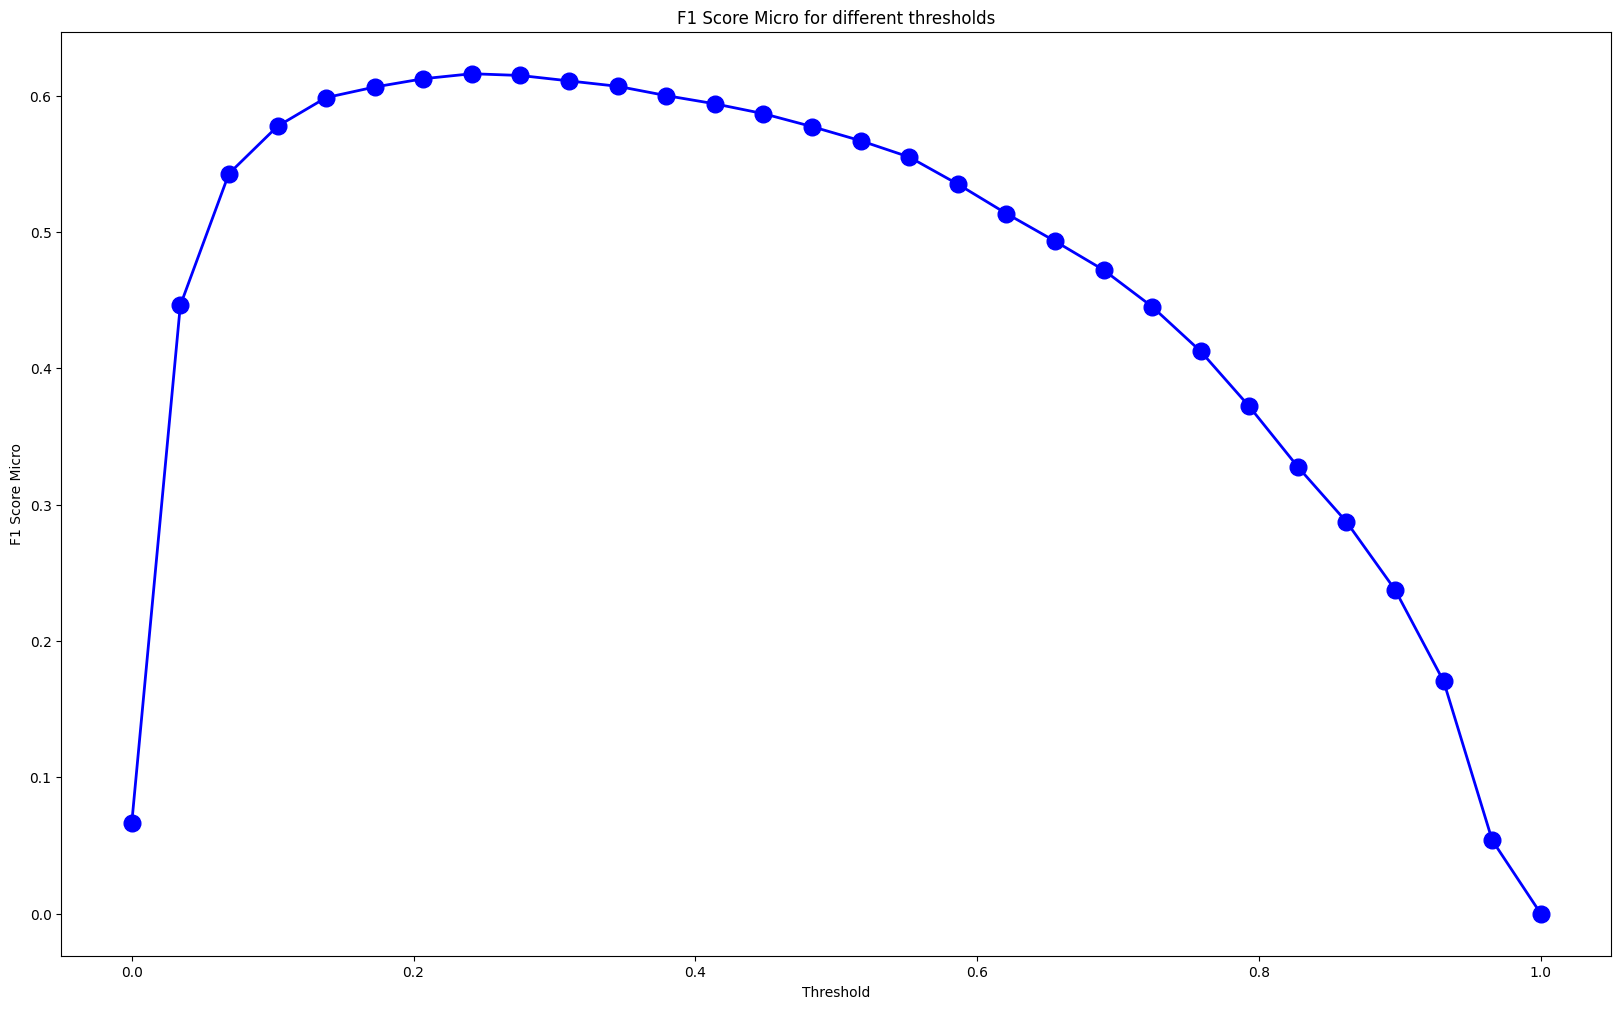

best threshold: 0.24137931034482757
Prediction: ('Novel',)
True label: ('Novel',)
Jaccard value: 1.0

Prediction: ("Children's literature",)
True label: ("Children's literature",)
Jaccard value: 1.0

Prediction: ('Fiction', 'Novel')
True label: ('Fiction', 'Novel')
Jaccard value: 1.0

Prediction: ('Non-fiction',)
True label: ('Non-fiction',)
Jaccard value: 1.0

Prediction: ("Children's literature", 'Fiction', 'Young adult literature')
True label: ("Children's literature", 'Fiction', 'Young adult literature')
Jaccard value: 1.0



In [ ]:
# Flatten the outputs and labels lists
all_probabilities_ = np.vstack(all_probabilities)
all_true_labels_ = np.vstack(all_true_labels)
# display first label
print(all_true_labels_[2])
# decode the labels
all_true_labels_decoded = mlb.inverse_transform(all_true_labels_)
print(all_true_labels_decoded[2])


# Determine the predicted labels based on the threshold
threshold = 0.24
all_predictions = (all_probabilities_ > threshold).astype(int)
# display first 5 predictions
print(all_predictions[2])
# decode the predictions
all_predictions_decoded = mlb.inverse_transform(all_predictions)
print(all_predictions_decoded[2])

# Calculate the micro-averaged accuracy
micro_f1 = f1_score(all_true_labels_, all_predictions, average='micro')

print(f'micro accuracy: {micro_f1}')

# Create a list of thresholds and empty lists for the f1 scores
thresholds = np.linspace(0, 1, 30)
f1_scores = []
for threshold in thresholds:
    #print(f"running threshold: {threshold}")
    predictions = (all_probabilities_ > threshold).astype(int)
    f1_scores.append(f1_score(all_true_labels_, predictions, average='micro'))

# Plot the data
plt.figure(figsize=(20, 12))
plt.plot(thresholds, f1_scores, marker='o', color='blue', linewidth=2, markersize=12)
plt.title('F1 Score Micro for different thresholds')
plt.xlabel('Threshold')
plt.ylabel('F1 Score Micro')
plt.show()

# Find the best threshold
best_threshold = thresholds[np.argmax(f1_scores)]
print(f'best threshold: {best_threshold}')

# calculate jaccard value for each prediction with its true label
jaccard_list = []
for i in range(len(all_true_labels_)):
    jaccard_list.append(jaccard_score(all_true_labels_[i], all_predictions[i], average='micro'))

# get the index of the top 5 highest jaccard value and print its decoded prediction and true label
top_5_highest_jaccard = np.argsort(jaccard_list)[-5:]
for i in top_5_highest_jaccard:
    print(f"Prediction: {all_predictions_decoded[i]}")
    print(f"True label: {all_true_labels_decoded[i]}")
    print(f"Jaccard value: {jaccard_list[i]}")
    print()


## 3.7 Visualize Trainings-/Test Loss

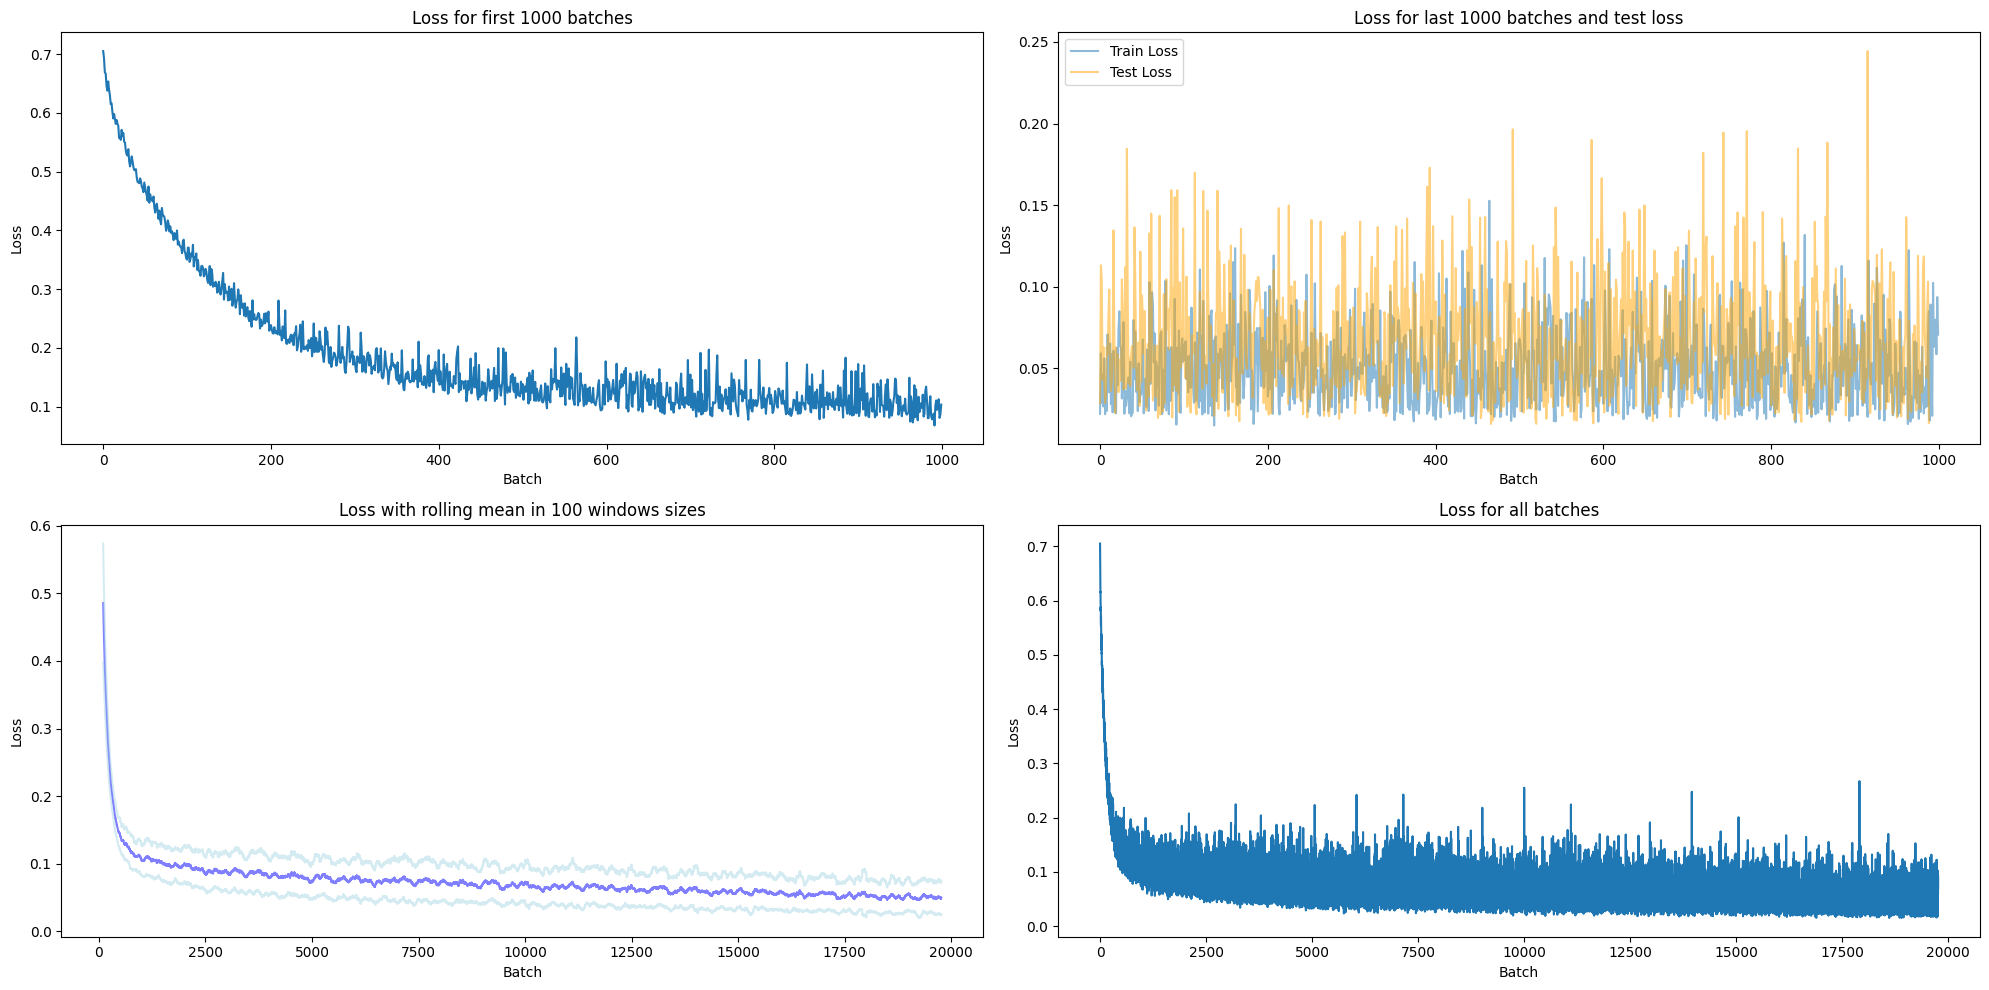

In [ ]:
# Create 4 subplots in one figure for the list_loss visualization
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes[0, 0].plot(loss_list[:1000])
axes[0, 0].set_title('Loss for first 1000 batches')
axes[0, 0].set_xlabel('Batch')
axes[0, 0].set_ylabel('Loss')

# plot for the last 1000 batches
axes[0, 1].plot(loss_list[-1000:], alpha = 0.5)
axes[0, 1].plot(test_loss_list, color = "orange", alpha = 0.5)
axes[0, 1].legend(['Train Loss', 'Test Loss'])
axes[0, 1].set_title('Loss for last 1000 batches and test loss')
axes[0, 1].set_xlabel('Batch')
axes[0, 1].set_ylabel('Loss')

# plot with rolling mean plus std in 100 windows sizes
axes[1, 0].plot(pd.Series(loss_list).rolling(100).mean(), color = 'blue', alpha=0.5)
axes[1, 0].plot(pd.Series(loss_list).rolling(100).mean() + pd.Series(loss_list).rolling(100).std(), color='lightblue', alpha=0.5)
axes[1, 0].plot(pd.Series(loss_list).rolling(100).mean() - pd.Series(loss_list).rolling(100).std(), color='lightblue', alpha=0.5)
axes[1, 0].set_title('Loss with rolling mean in 100 windows sizes')
axes[1, 0].set_xlabel('Batch')
axes[1, 0].set_ylabel('Loss')

# plot everything
axes[1, 1].plot(loss_list)
axes[1, 1].set_title('Loss for all batches')
axes[1, 1].set_xlabel('Batch')
axes[1, 1].set_ylabel('Loss')

plt.tight_layout()
plt.show()



## 3.8 Test - Read Test Transformer Model

Hier in diesem Abschnitt laden wir unseren Transformer, welches wir ganz am Anfang genutzt haben für unsere Klassifikation. Hier haben wir mit der gleichen Learning_rate trainiert, jedoch nur mit 2 Epochen statt 5. Hier erkennen wir, dass das länger trainieren einen Einfluss auf den F1-Micro Score hat. Keinen allzu grossen, jedoch eine Verbesserung von 0.02. 

In [ ]:
# Assume you have a CUDA-capable GPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load your model
model2 = AutoModelForSequenceClassification.from_pretrained('models/model-test')

# Move your model to the device
model2.to(device)

# Move model to evaluation mode
model2.eval()

# Initialize sigmoid function
sigmoid = Sigmoid()

# Store probabilities and true labels
all_probabilities = []
all_true_labels = []

# No need to track gradients for validation
with torch.no_grad():
    for batch in tqdm(test_loader):  # Replace with your data loader
        # Unpack batch and move to the device
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        
        # Forward pass, get logits
        outputs = model2(input_ids, attention_mask=attention_mask)
        
        # Apply sigmoid to logits
        probabilities = sigmoid(outputs.logits)
        
        # Move probabilities and labels back to CPU if on GPU
        all_probabilities.append(probabilities.cpu().numpy())
        all_true_labels.append(labels.cpu().numpy())

100%|██████████| 989/989 [01:36<00:00, 10.23it/s]


micro accuracy: 0.5907122232916265


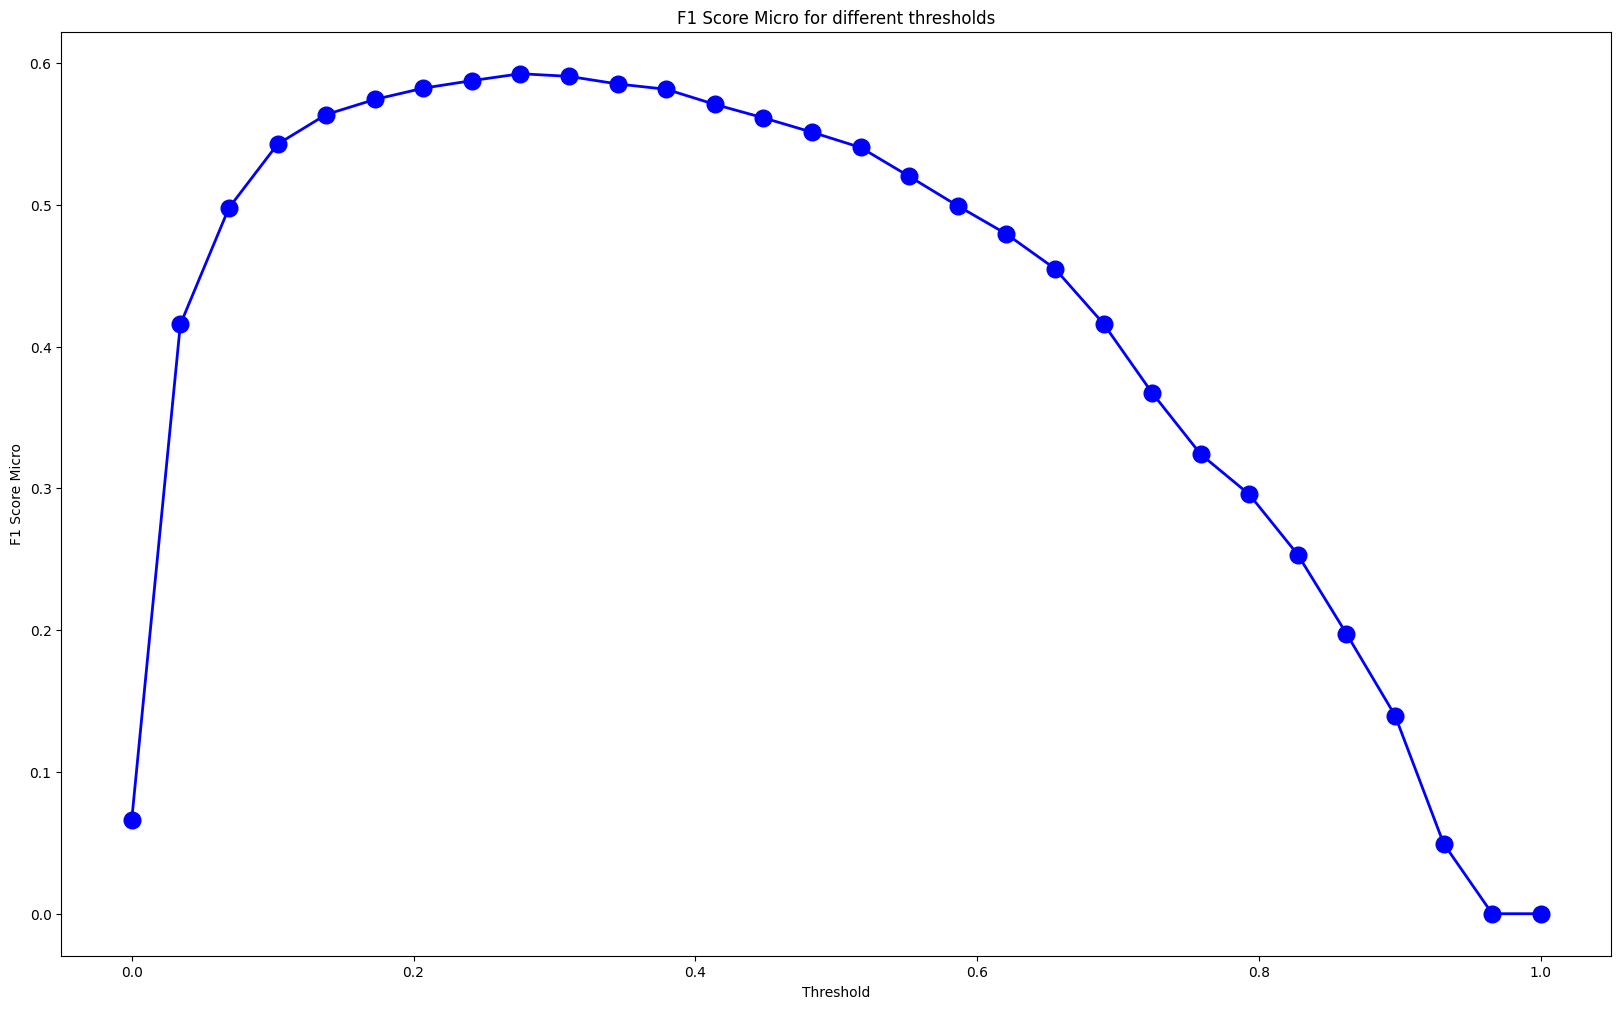

In [ ]:
# Flatten the outputs and labels lists
all_probabilities_ = np.vstack(all_probabilities)
all_true_labels_ = np.vstack(all_true_labels)

# Determine the predicted labels based on the threshold
threshold = 0.3
all_predictions = (all_probabilities_ > threshold).astype(int)

# Calculate the micro-averaged accuracy
micro_f1 = f1_score(all_true_labels_, all_predictions, average='micro')

print(f'micro accuracy: {micro_f1}')

# Create a list of thresholds and empty lists for the f1 scores
thresholds = np.linspace(0, 1, 30)
f1_scores = []
for threshold in thresholds:
    #print(f"running threshold: {threshold}")
    predictions = (all_probabilities_ > threshold).astype(int)
    f1_scores.append(f1_score(all_true_labels_, predictions, average='micro'))

# Plot the data
plt.figure(figsize=(20, 12))
plt.plot(thresholds, f1_scores, marker='o', color='blue', linewidth=2, markersize=12)
plt.title('F1 Score Micro for different thresholds')
plt.xlabel('Threshold')
plt.ylabel('F1 Score Micro')
plt.show()




# 4 übersicht und Verlgiech mit Paper

Hier stellen wir eine Übersichtstabelle unserer Modelle sowie deren Threshold und erreichten F1-Micro Score dar und vergleichen diese direkt mit einem [Paper](https://arxiv.org/pdf/2203.11258v1.pdf), welches wir im Internet noch gefunden haben. 

| Model | Threshold | F1-Micro Score |
| --- | --- | --- |
| Random Forest Classifier & n_grams=(1, 1) | 0.2 | 0.5469 |
| Random Forest Classifier & n_grams=(1, 2) | 0.2 | 0.5416 |
| Deep Learning Model - CNN - Simple | | |
| Deep Learning Model - CNN - Complex | | |
| Deep Learning Model - CNN - Deep Complex | | |
| Deep Learning Model - Transformers - lr = 1e-5, n_epoch = 5|  0.24 | **0.6154** | 
| Deep Learning Model - Transformers - lr = 1e-5, n_epoch = 2 | 0.26 | 0.5907 |
| Paper - BERT | -- | 0.5818 | 
| Paper - BERT + TextRank | -- | 0.5894 |
| Paper - Bert+Random | -- | 0.5936 | 

Aus dem Paper ist nicht klar ersichtlich welchen Threshold genutzt wurde. Was man jedoch erkennt, ist das unser Deep Learning Model - Transformers mit einem F1-Micro Score von 0.6154 besser ist als das beste Paper Modell mit 0.5936. Wir können somit sagen, dass wir eine bessere Klassifikation erreicht haben als das Paper, dies jedoch nur mit Vorsicht, da das Preprocessing sowie die Konfidenzintervalle beim Paper als auch bei uns nicht bekannt ist. Aus diesem Grund können wir den Erfolg nur mit Vorsicht geniessen :)


# 5 Unser Fazit zu npr MC1

Ben   
Mir hat die Mini-Challenge1 spass gemacht. Ich bin froh, hat uns Fernando aufgemuntert, einen komplexeren Task zu wählen (Mutli-Class Genre Klassifikation statt Single-Class Klassifkation). Ich persönlich konnte mir somit die Frage stellen, wie man Multi-Class Klassifikation ausführt mit dieser Mini-Challenge beantworten. Auch fand ich es gut in der Mini-Challenge, dass wir zuerst einen Machine Learning Ansatz und anschliessend einen Deep Learning Ansatz ausprobieren konnten. Was meiner Meinung gefehlt hat in dieser Challenge ist der Zugriff zu einem GPU Rechner. Ich habe zwar einen Gaming Computer auf dem ich meine Modelle trainieren und Fine Tunen konnte, jedoch sollte dies für den Studiengang Data Science allen zur Verfügung stehen. 


Yannic 
